In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objs as go
import plotly
import plotly.subplots as sp
import plotly.io as pio
import os
from cloudvolume import CloudVolume as cv
from caveclient import CAVEclient
import meshparty
from meshparty import trimesh_vtk, trimesh_io 
import pygsheets
import ast
from collections import Counter
import time
import pickle

vol =cv('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', agglomerate=True, use_https=True)
client = CAVEclient('zheng_ca3')

isotropy = [5,5,2]


In [143]:
# load MF-PyC ground truth table 
gc = pygsheets.authorize(service_file = "./hippca3-8126bea0d603.json")
sheet = gc.open('all_pyramidal_cells')
worksheet = sheet.worksheet('title','MF-pyr')
worksheet2 = sheet.worksheet('title','all_pyr_v2_remove_dupes')
mfpc_df = worksheet.get_as_df(start='A4')
pc_df = worksheet2.get_as_df(start='A1')

/opt/anaconda3/envs/allensdk/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')


In [4]:
# get latest ~600 target PC roots

nuclei_coord_in_vol = mfpc_df[['x','y','z']].to_numpy()
latest_roots_PC = []
print('Getting latest roots for PC...')  
cell_ids_scatter = vol.scattered_points(nuclei_coord_in_vol)
for i in range(0, len(nuclei_coord_in_vol)):
    if i % 100 == 0:
        print(i)
    cell_ID = [cell_ids_scatter.get(tuple(nuclei_coord_in_vol[i,:]))]
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0]-150, nuclei_coord_in_vol[i,1], nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]+150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]-150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        print("Failed to find neuron segment ID using nuclei center")
    else:
        if client.chunkedgraph.is_latest_roots(cell_ID[0]):
            latest_roots_PC.append(cell_ID[0])
        else:
            latest_roots_PC.append(client.chunkedgraph.suggest_latest_roots(cell_ID[0]))
latest_roots_PC_str = [str(num) for num in latest_roots_PC]


Getting latest roots for PC...


Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████| 636/636 [00:06<00:00, 90.87it/s]


0
100
200
300
400
500
600


In [15]:
# get all latest PC roots

gc = pygsheets.authorize(service_file = "./hippca3-8126bea0d603.json")
sheet2 = gc.open('all_pyramidal_cells')
worksheet2 = sheet2.worksheet('title','all_pyr_v2_remove_dupes')
pc_df = worksheet2.get_as_df()

nuclei_coord_in_vol = pc_df[['x','y','z']].to_numpy()
latest_roots_PC_all = []
print('Getting latest roots for PC...')  
cell_ids_scatter = vol.scattered_points(nuclei_coord_in_vol)
for i in range(0, len(nuclei_coord_in_vol)):
    if i % 100 == 0:
        print(i)
    cell_ID = [cell_ids_scatter.get(tuple(nuclei_coord_in_vol[i,:]))]
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0]-150, nuclei_coord_in_vol[i,1], nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]+150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]-150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        print("Failed to find neuron segment ID using nuclei center")
    else:
        if client.chunkedgraph.is_latest_roots(cell_ID[0]):
            latest_roots_PC_all.append(cell_ID[0])
        else:
            latest_roots_PC_all.append(client.chunkedgraph.suggest_latest_roots(cell_ID[0]))


/opt/anaconda3/envs/allensdk/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')


Getting latest roots for PC...


Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1835/1835 [00:23<00:00, 78.75it/s]


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [155]:
# load MF-PyC boutons returned by splitter

# Path to the pickle file
with open("./variables/mf_bouton_split_best_250302_all.pkl", "rb") as file:
    variable_loaded = pickle.load(file)       

# Display the loaded variable
bouton_info = pd.DataFrame(variable_loaded, columns=['nbouton','pre_mf_id', 'post_pyc_id', 'syn_cluster_center_vx','numsyn','bouton_vol_um3', 'bouton_bbx','syn_sv_id'])
print(len(bouton_info))


# filter out truncated boutons
bouton_info.reset_index(drop=True, inplace=True)
idx_truncated = [i for i, a in enumerate(bouton_info['syn_cluster_center_vx'].values) if 150 > a[-1] or 2090 < a[-1]]
bouton_info = bouton_info.drop(idx_truncated, axis=0)
bouton_info.reset_index(drop=True, inplace=True)
print(len(bouton_info))

# filter out duplicated rows
for col in bouton_info.columns:
    if bouton_info[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any():
        bouton_info[col] = bouton_info[col].apply(lambda x: tuple(x) if isinstance(x, (list, np.ndarray)) else x)
bouton_info = bouton_info.drop_duplicates(keep=False)
identical_rows = bouton_info[bouton_info.duplicated(keep=False)]
bouton_info['syn_cluster_center_vx'] = bouton_info['syn_cluster_center_vx'].apply(lambda x: np.array(x) if isinstance(x,tuple) else x)
print(len(bouton_info))


#double_bouton_info = bouton_info[bouton_info['nbouton'] == 'double_bouton']
single_bouton_info = bouton_info[bouton_info['nbouton'] == 'single_bouton']
single_bouton_info = single_bouton_info[single_bouton_info['bouton_vol_um3'] < 70]


# load double bouton info
file_paths = ["./variables/mf_double_bouton_split_best_250302_01.pkl", "./variables/mf_double_bouton_split_best_250302_02.pkl",
              "./variables/mf_double_bouton_split_best_250302_03.pkl"]


# Load the variable from the pickle file
variable_loaded = []
for i in range(0, len(file_paths)):
    with open(file_paths[i], 'rb') as f:
        loaded_variable = pickle.load(f)
        
        # bouton_info: [MF pre_id, PyC post_id, syn_cluster_center, num_syn, bouton_vol]
        variable_loaded = variable_loaded + loaded_variable

length_data = [len(sublist) for sublist in variable_loaded]
possible_len = list(set(length_data))
print(possible_len)
len0 = [sublist for sublist in variable_loaded if len(sublist)==0]  # empty result
len1 = [sublist for sublist in variable_loaded if len(sublist)==1]  # single bouton result
len2 = [sublist for sublist in variable_loaded if len(sublist)==2]  # double bouton result
len3 = [sublist for sublist in variable_loaded if len(sublist)==3]  # double bouton result
len4 = [sublist for sublist in variable_loaded if len(sublist)==4]  # no mesh available

print('number of empty results', len(len0))  
print('number of single boutons', len(len1))
print('number of double boutons', len(len2))
print('number of triple boutons', len(len3))
print('number of missing meshes', len(len4))


variable_flattened = []
for sublist in variable_loaded:
    if len(sublist) == 0:
        continue
    elif len(sublist) == 1:
        continue
    elif len(sublist) == 2:
        variable_flattened.extend(sublist)
    elif len(sublist) == 3:
        variable_flattened.extend(sublist)
    else:
        continue


length_data = [len(sublist) for sublist in variable_flattened]
possible_len = list(set(length_data))
print(possible_len)

len8 = [sublist for sublist in variable_flattened if len(sublist)==8]  # double bouton result

variable_final = len8
with open("./variables/mf_double_bouton_split_best_250302_all.pkl", "wb") as file:
    pickle.dump(variable_final, file)       

with open("./variables/mf_double_bouton_split_best_250302_all.pkl", "rb") as file:
    variable_loaded = pickle.load(file)    

double_bouton_info = pd.DataFrame(variable_loaded, columns=['nbouton','pre_mf_id', 'post_pyc_id', 'syn_cluster_center_vx','numsyn','bouton_vol_um3', 'bouton_bbx','syn_sv_id'])
print(len(bouton_info))
double_bouton_info = double_bouton_info[double_bouton_info['nbouton'] == 'double_bouton']

# filter out truncated boutons
double_bouton_info.reset_index(drop=True, inplace=True)
idx_truncated = [i for i, a in enumerate(double_bouton_info['syn_cluster_center_vx'].values) if 150 > a[-1] or 2090 < a[-1]]
double_bouton_info = double_bouton_info.drop(idx_truncated, axis=0)
double_bouton_info.reset_index(drop=True, inplace=True)
print(len(double_bouton_info))

# filter out duplicated rows
for col in double_bouton_info.columns:
    if double_bouton_info[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any():
        double_bouton_info[col] = double_bouton_info[col].apply(lambda x: tuple(x) if isinstance(x, (list, np.ndarray)) else x)
double_bouton_info = double_bouton_info.drop_duplicates(keep=False)
identical_rows = double_bouton_info[double_bouton_info.duplicated(keep=False)]
double_bouton_info['syn_cluster_center_vx'] = double_bouton_info['syn_cluster_center_vx'].apply(lambda x: np.array(x) if isinstance(x,tuple) else x)
print(len(double_bouton_info))

# remove rows where presynaptic neuron is pyr cells
double_bouton_info = double_bouton_info[double_bouton_info['bouton_vol_um3'] < 70]
print(len(double_bouton_info))

bouton_info = pd.concat([single_bouton_info, double_bouton_info], ignore_index=True)

# remove rows where bouton volume is 0.0 if there is any
print(len(bouton_info))
bouton_info_zero = bouton_info[bouton_info['bouton_vol_um3'] <= 0.5]
bouton_info = bouton_info[bouton_info['bouton_vol_um3'] > 0.5]
print(len(bouton_info_zero))
print(len(bouton_info))

bouton_info = bouton_info.reset_index(drop=True)


23161
23161
23145
[0, 1, 2, 3, 4]
number of empty results 23944
number of single boutons 245
number of double boutons 548
number of triple boutons 14
number of missing meshes 1
[8, 6]
23145
1136
1132
1132
24262
166
24096


In [459]:
bouton_info['syn_cluster_center_vx'] = bouton_info['syn_cluster_center_vx'].apply(lambda x: np.array(x) if isinstance(x,tuple) else x)


<class 'numpy.ndarray'>


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_6154/597197375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bouton_info['syn_cluster_center'] = bouton_info['syn_cluster_center'].apply(lambda x: np.array(x) if isinstance(x,tuple) else x)


Text(0.5, 1.0, 'Pairs of boutons, same MF')

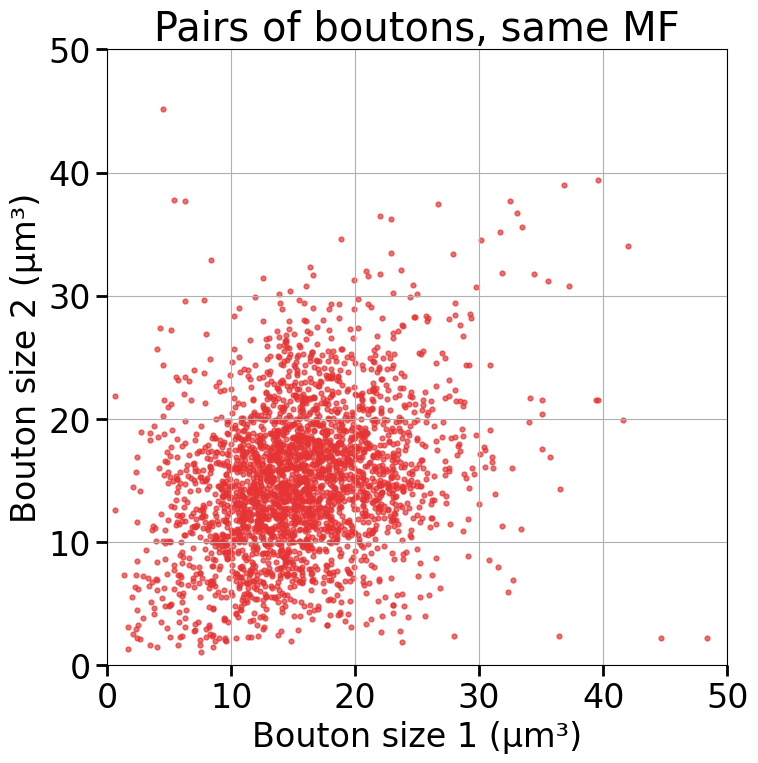

In [221]:
#multi_bouton_info = bouton_info[bouton_info.duplicated(subset='pre_mf_id', keep=False)]
import itertools
multi_bouton_info = bouton_info.groupby('pre_mf_id')['bouton_vol_um3','syn_cluster_center_vx'].apply(list)
#multi_bouton_info = bouton_info.groupby('pre_mf_id')['pre_mf_id'].apply(list)


def get_non_duplicated_pairs(group):
    pairs = []
    indices = list(group.index)
    for i,j in itertools.combinations(indices,2):
        p1,p2 = group.loc[i, 'syn_cluster_center_vx'], group.loc[j,'syn_cluster_center_vx']
        p1_um = p1  * np.array([0.018,0.018,0.045])
        p2_um = p2  * np.array([0.018,0.018,0.045])
        d = np.linalg.norm(p1_um - p2_um)
        if d > 5:
            v1,v2 = group.loc[i, 'bouton_vol_um3'], group.loc[j, 'bouton_vol_um3']
            pairs.append((v1,v2))
    return pairs
'''
pairs1 = []
mf_pair_ids = []
for vol_list in multi_bouton_info['bouton_vol_um3']:
    for vol1, vol2 in itertools.combinations(vol_list,2):
        pairs1.append((vol1,vol2))
x_val, y_val = zip(*pairs) if pairs2 else ([],[])
'''

pairs2 = bouton_info.groupby('pre_mf_id').apply(get_non_duplicated_pairs)
x_val = [x for sublist in pairs2 for x, _ in sublist]
y_val = [y for sublist in pairs2 for _, y in sublist]

plt.figure(figsize=(8,8))
plt.tick_params(axis='both', which='major', width=2, length=8)
plt.grid(True)
plt.scatter(x_val, y_val, s=12, color=np.array([0.9,0.2,0.2]), alpha=0.7)
plt.xlabel('Bouton size 1 (\u03bcm\u00b3)')
plt.ylabel('Bouton size 2 (\u03bcm\u00b3)')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Pairs of boutons, same MF')

In [ ]:
# cases where the two boutons from same MF are correlated

pairs = []
for i in range(len(bouton_info)):
    for j in range(i+1, len(bouton_info)):
        if bouton_info.loc[i, 'pre_mf_id'] == bouton_info.loc[j, 'pre_mf_id']:
            y1, y2 = bouton_info.loc[i,'bouton_vol_um3'], bouton_info.loc[j, 'bouton_vol_um3']
            if abs(y1-y2) < 1:
                pairs.append((bouton_info.iloc[i], bouton_info.iloc[j]))
    if i % 100 == 0:
        print(i)

print(len(pairs))

vb1 =[]
vb2 =[]
correlated_bouton_mfids = []
correlated_bouton_pyr1 = []
correlated_bouton_pyr2 = []

for i in range(0, len(pairs)):
    vb1.append((pairs[i][0]['bouton_vol_um3']))
    vb2.append((pairs[i][1]['bouton_vol_um3']))
    correlated_bouton_mfids.append((pairs[i][0]['pre_mf_id']))
    correlated_bouton_pyr1.append((pairs[i][0]['post_pyc_id']))
    correlated_bouton_pyr2.append((pairs[i][1]['post_pyc_id']))
    
plt.figure(figsize=(7,7))
plt.grid(True)
plt.scatter(vb1, vb2, s=10, color=np.array([0.9,0.2,0.2]), alpha=0.7)
plt.xlabel('Bouton volume 1')
plt.ylabel('Bouton volume 2')
plt.xlim([0,70])
plt.ylim([0,70])

print((pairs[0][0]['pre_mf_id']))
print((pairs[0][1]['pre_mf_id']))
same_pyr = [a for a, b in zip(correlated_bouton_pyr1,correlated_bouton_pyr2) if a==b]
mf_to_same_pyr = [c for a, b, c in zip(correlated_bouton_pyr1,correlated_bouton_pyr2,correlated_bouton_mfids) if a==b]
print(same_pyr)
print(mf_to_same_pyr)

In [56]:
# update pc root columns to latest pc roots

pc_roots = bouton_info['post_pyc_id'].values
pc_roots_list = list(set(pc_roots))
not_latest_roots = [a for a in pc_roots_list if a not in latest_roots_PC]
print(len(not_latest_roots))

for i in range(0, len(not_latest_roots)):
    bouton_info.loc[bouton_info['post_pyc_id'] == not_latest_roots[i], 'post_pyc_id'] =client.chunkedgraph.suggest_latest_roots(not_latest_roots[i]) 
print('done')

aa = list(mfpc_df['segid_0114'].values)
bb = list(latest_roots_PC)
not_latest_roots = [a for a in aa if a not in bb]
print(len(not_latest_roots))

for i in range(0,len(not_latest_roots)):
    mfpc_df.loc[mfpc_df['segid_0114'] == not_latest_roots[i], 'segid_0114'] =client.chunkedgraph.suggest_latest_roots(not_latest_roots[i]) 
print('done')

aa = list(mfpc_df['segid_0114'].values)
bb = list(latest_roots_PC)
not_latest_roots = [a for a in aa if a not in bb]
print(len(not_latest_roots))
print(aa==bb)

102
done
0
done
0
True


In [57]:
# group boutons by target pc

# make dictionary {pc_root_id : GT_numMF}
#dict_GTnumMF = dict(zip(mfpc_df['segid_0114'], mfpc_df['GT_numMF']))
bouton_vols_grouped = []
used_preMF_grouped = []

#for i in range(0,1):
for i in range(0,len(mfpc_df['segid_0114'].values)):
    this_vols = bouton_info.loc[bouton_info['post_pyc_id']==mfpc_df['segid_0114'].values[i], 'bouton_vol_um3'].tolist()
    bouton_vols_grouped.append(this_vols)
    
    this_preMF = bouton_info.loc[bouton_info['post_pyc_id']==mfpc_df['segid_0114'].values[i], 'pre_mf_id'].tolist()
    unique_preMF = list(set(this_preMF))
    used_preMF_grouped.append(unique_preMF)
    
    
print('done')    
print(len(bouton_vols_grouped))
print(len(used_preMF_grouped))



done
636
636


In [29]:
# investigate why many MFs are missing in the data for large pyr cells


with open('./variables/mf_group_th5_250302.pkl', 'rb') as f:  
    mf_group = pickle.load(f)
print(len(mf_group))

len_group = [len(item) for item in bouton_vols_grouped]
gt_numMF = mfpc_df['GT_numMF'].values.tolist()
gt_pc_roots = mfpc_df['segid_0114'].values.tolist()

#print((len_group))
#print(gt_numMF)

numMF_thresh = 200
pc_large_numMF = [a for a,b in zip(gt_pc_roots, gt_numMF) if b > numMF_thresh]
large_numMF = [b for b in gt_numMF if b > numMF_thresh]
obtained_numMF = [a for a,b in zip(len_group, gt_numMF) if b > numMF_thresh]
print(pc_large_numMF)
print(large_numMF)
print(obtained_numMF)



639
[648518346442090245, 648518346436160639, 648518346447524619, 648518346451309998, 648518346451022260, 648518346451792508, 648518346439282242, 648518346452912185]
[292, 287, 255, 250, 227, 224, 207, 206]
[244, 242, 265, 254, 221, 230, 199, 211]


In [209]:

preMF_to_large_numMF = [sublist for sublist in mf_group if sublist[0]==648518346451792508]
missing_mfs = [648518346372685964, 648518346372767884, 648518346404904551, 648518346404927591, 648518346424889089, 648518346434595498, 648518346439830475, 648518346440201675, 648518346440207349, 648518346440235211, 648518346440318053, 648518346440462911, 648518346440508149, 648518346440511221, 648518346440720373, 648518346440771275, 648518346440882677, 648518346440983797, 648518346441318389, 648518346441324277, 648518346441337077, 648518346441408891, 648518346442113784, 648518346442787647, 648518346442856030, 648518346444590140, 648518346444590908, 648518346444609340, 648518346445238248, 648518346445878076, 648518346445961788, 648518346446477821, 648518346446923580, 648518346447168060, 648518346447181884, 648518346448344635, 648518346448363579, 648518346448798779, 648518346448802875, 648518346450294075, 648518346452225734, 648518346467131046, 648518346467548582, 648518346468416934, 648518346468499366, 648518346468524198, 648518346468587686, 648518346470073254, 648518346470115494]
missing_mfs_pc = 648518346451792508

synn = client.materialize.synapse_query(pre_ids=missing_mfs, post_ids=missing_mfs_pc, bounding_box=None, bounding_box_column='post_pt_position', 
            timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
            split_positions=False, desired_resolution=[18,18,45], materialization_version=None, 
            synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
print(len(missing_mfs))
#print(len(synn))

with open('./variables/potential_mf_ids_250302.pkl','rb') as f: 
    mf_proof_ids_flat = pickle.load(f)

missing_mfs_not_in_mf_list = [a for a in missing_mfs if a in mf_proof_ids_flat] 
print(missing_mfs_not_in_mf_list)
print(len(missing_mfs))
print(len(missing_mfs_not_in_mf_list))
freqq = synn['pre_pt_root_id'].value_counts()
print(freqq)

49
[648518346441324277, 648518346442856030, 648518346446477821, 648518346468524198]
49
4
648518346424889089    10
648518346444590140    10
648518346440318053     7
648518346450294075     6
648518346452225734     6
648518346448363579     5
648518346448798779     5
648518346440720373     5
648518346442856030     5
648518346444609340     5
648518346468587686     5
648518346440882677     5
648518346467131046     5
648518346440983797     5
648518346467548582     5
648518346470115494     4
648518346372767884     4
648518346445878076     4
648518346440462911     4
648518346440201675     3
648518346468499366     3
648518346441318389     3
648518346445961788     3
648518346442787647     3
648518346446923580     3
648518346440508149     3
648518346441324277     3
648518346470073254     3
648518346439830475     3
648518346442113784     3
648518346468416934     3
648518346441337077     3
648518346446477821     3
648518346468524198     2
648518346440511221     2
648518346404927591     2
64851834644

In [161]:
with open('./variables/potential_mf_ids_250225.pkl','rb') as f: 
    mf_proof_ids_flat = pickle.load(f)


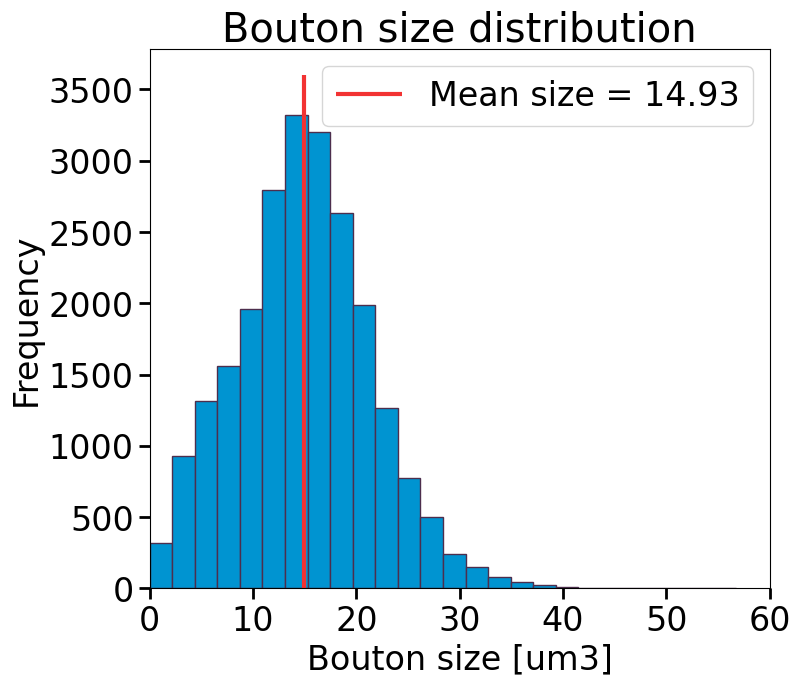

In [222]:
peacock = (0,0.58,0.82)
coral = (0.95,0.2,0.2)
pistachio = (0.7,0.9,0.6)
purple = (0.7,0.35,0.7)
orange = (0.95,0.7,0.1)

bouton_size_all = single_bouton_info['bouton_vol_um3'].values
mean_size = sum(bouton_size_all) / len(bouton_size_all)
plt.figure(figsize=(8, 7))  
plt.tick_params(axis='both', which='major', width=2, length=8)
plt.rcParams.update({'font.size': 24})
plt.hist(bouton_size_all, bins=26, color=peacock, edgecolor=(0.3,0.18,0.3))
plt.vlines(mean_size, 0, 3600, colors=coral, linewidth=3, linestyle='-', label='Mean size = '+str(round(mean_size,2)))
plt.xlabel('Bouton size [um3]')
plt.ylabel('Frequency')
plt.xlim([0,60])
plt.legend()
plt.title('Bouton size distribution')


bouton_vol_sorted, gt_numMF_sorted, used_preMF_sorted = zip(*sorted(zip(bouton_vols_grouped, gt_numMF, used_preMF_grouped), key=lambda x: x[1]))
bouton_vol_sorted = list(bouton_vol_sorted)
gt_numMF_sorted = list(gt_numMF_sorted)
used_preMF_sorted = list(used_preMF_sorted)

#del gt_numMF_sorted[0]
#del bouton_vol_sorted[0]


In [25]:
# get curve distance, nuclei size, depth for target pyc
latest_pc_roots = latest_roots_PC
curve_d = np.zeros((1,len(latest_pc_roots)))
nuc_size = np.zeros((1,len(latest_pc_roots)))
depth =  np.zeros((1,len(latest_pc_roots)))

for i in range(0, len(latest_pc_roots)):
    idx_target = latest_roots_PC_all.index(client.chunkedgraph.suggest_latest_roots(latest_pc_roots[i]))
    curve_d[0][i] = pc_df['curve_distance'].values[idx_target]
    if pc_df['nuc_size_um3'].values[idx_target] == '':
        nuc_size[0][i] = None
    else:
        nuc_size[0][i]= pc_df['nuc_size_um3'].values[idx_target]
    depth[0][i] = pc_df['depth_microns'].values[idx_target]
print('Done')

Done


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/1902928986.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(curve_d_extended, bouton_size_extended, s=2, c=peacock)


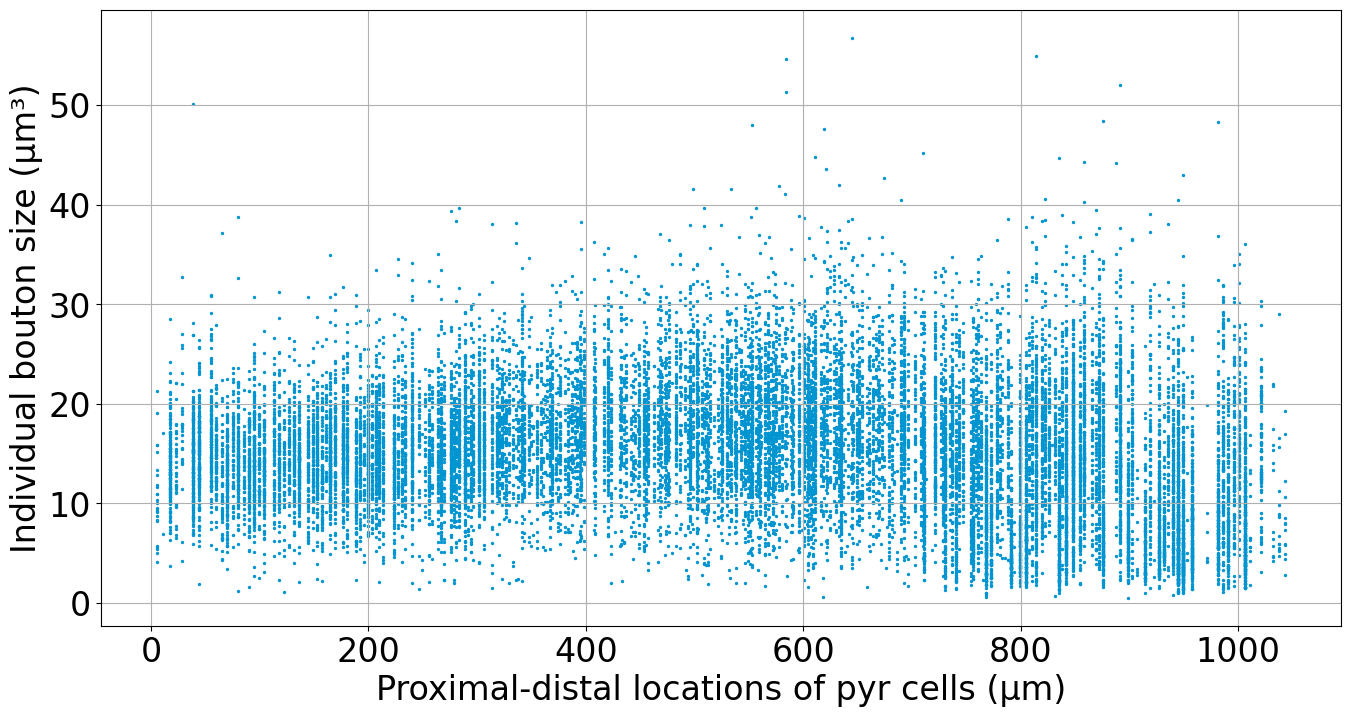

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/1902928986.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(curve_d_extended, bouton_size_extended, s=4, c=peacock, alpha=0.32)


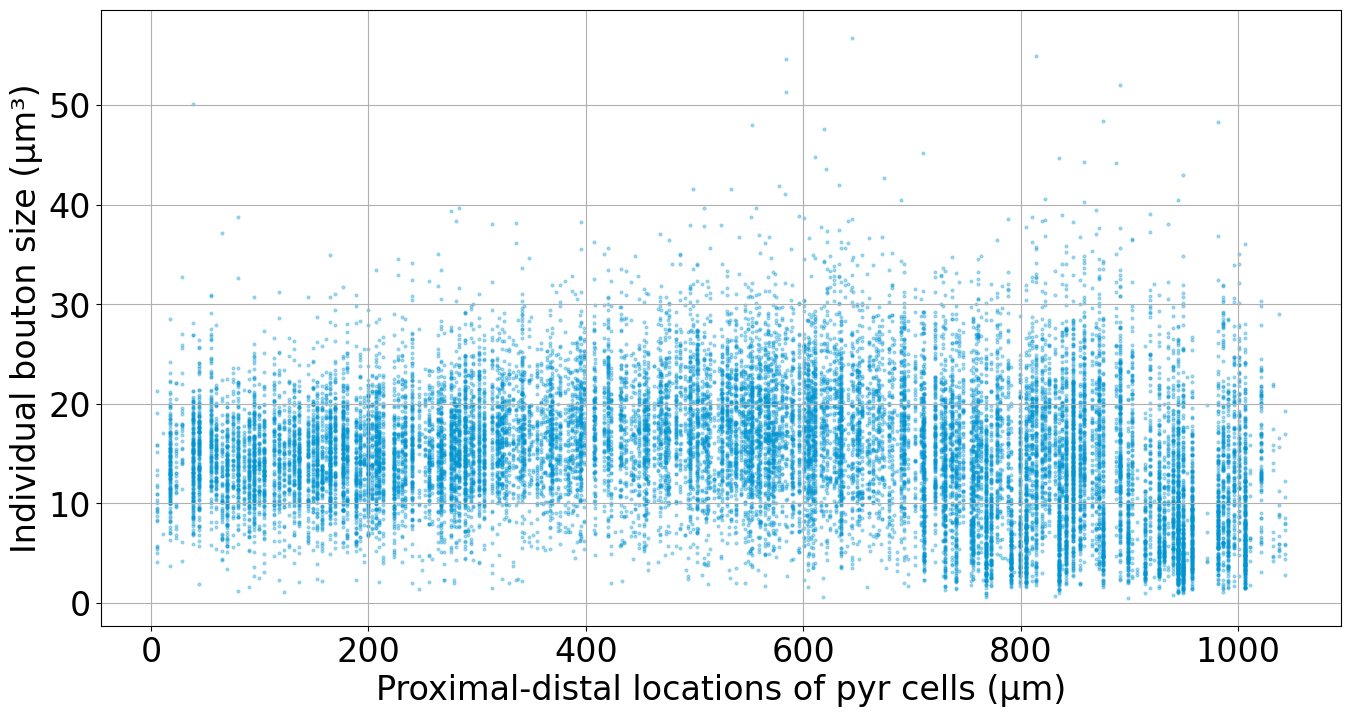

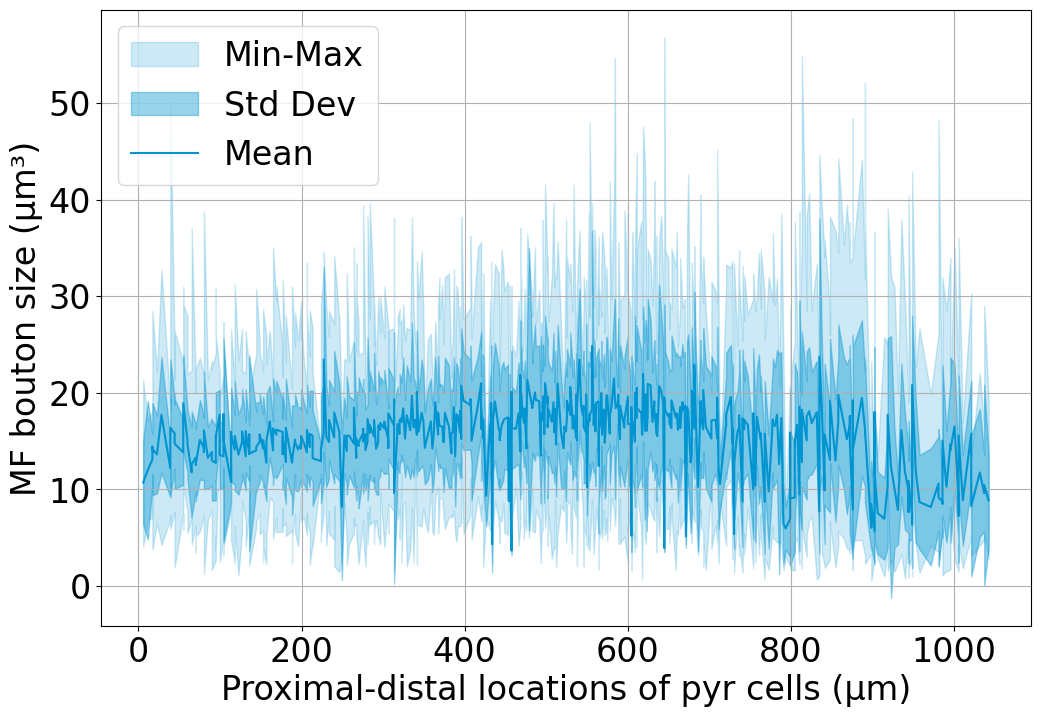

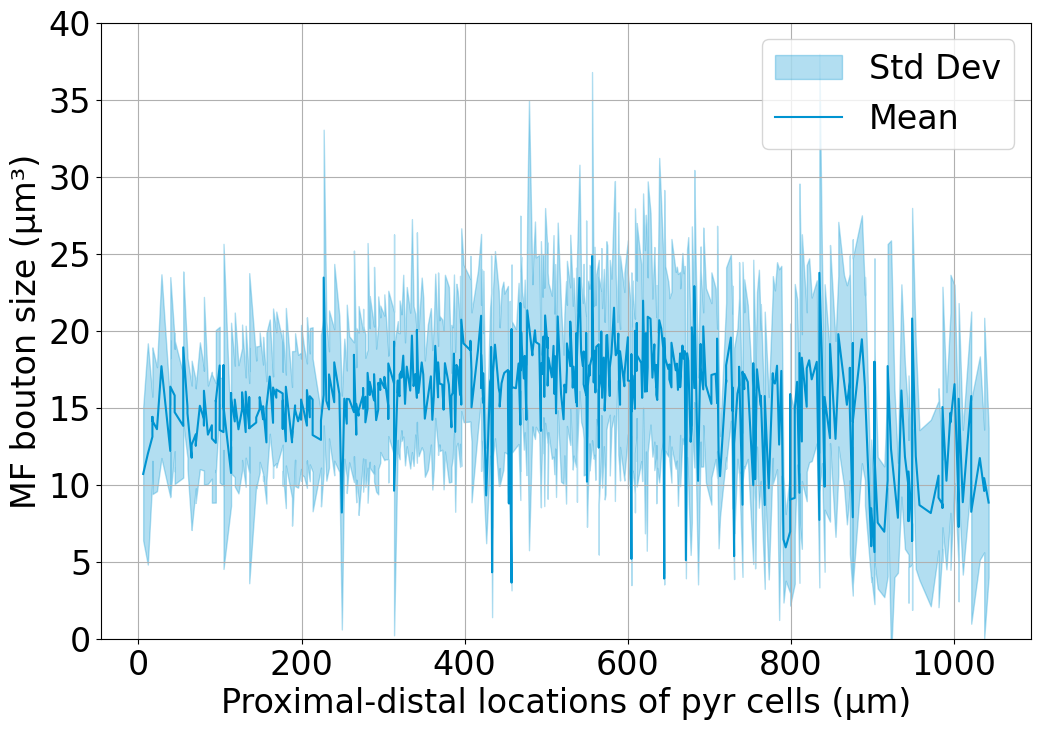

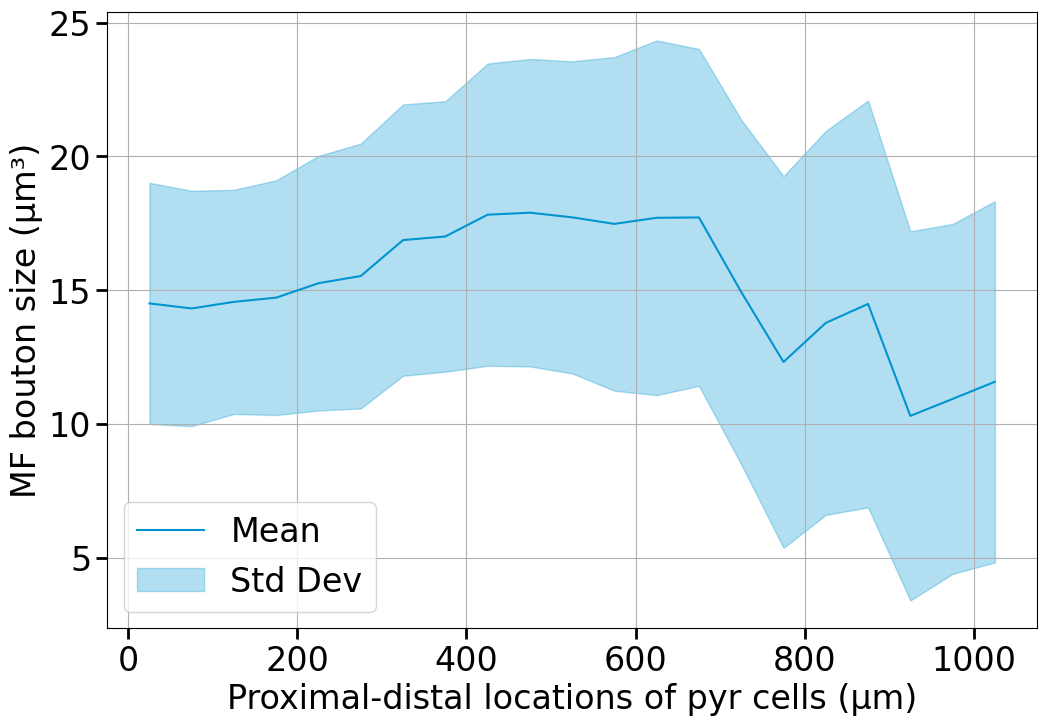

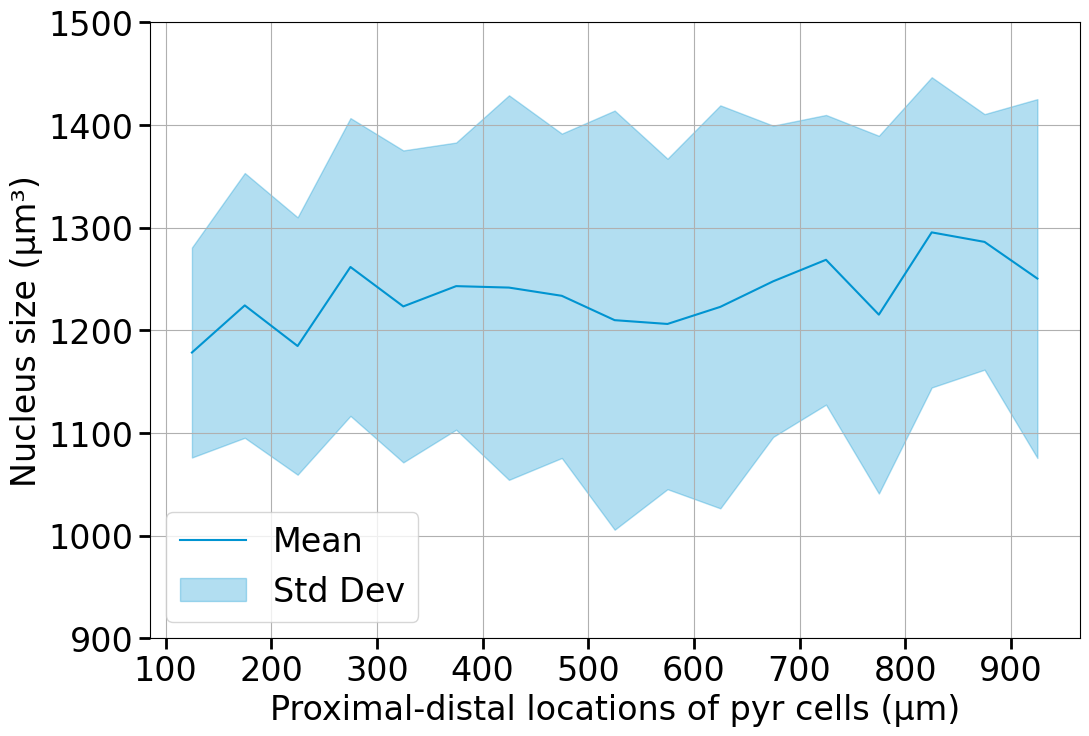

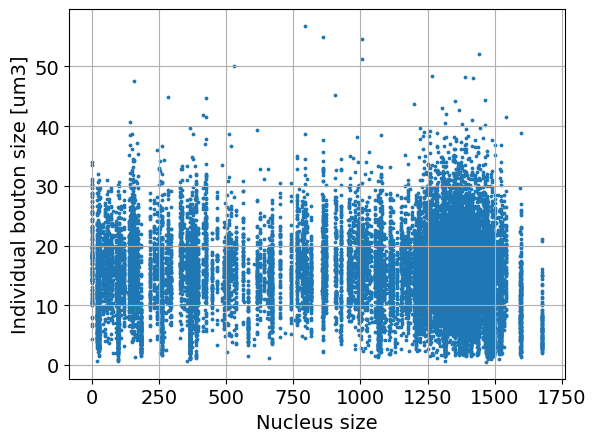

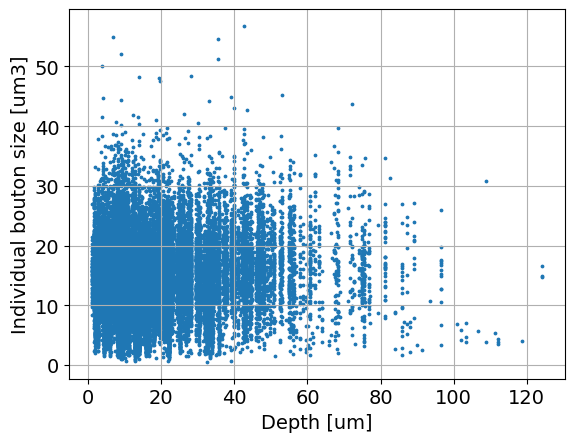

In [297]:
# draw curve d, nuc_size, depth vs individual bouton size for target pyc

curve_d_extended = []
nuc_size_extended = []
depth_extended = []
bouton_size_extended = []
bins = np.linspace(0,1100,45)

mins_d = []
maxs_d = []
means_d = []
stds_d = []
d_ribbon = []

for i in range(len(curve_d[0])):
    curve_d_extended.extend([curve_d[0][i]] * len(bouton_vols_grouped[i]))
    bouton_size_extended.extend(bouton_vols_grouped[i])
    nuc_size_extended.extend([nuc_size[0][i]] * len(bouton_vols_grouped[i]))
    depth_extended.extend([depth[0][i]] * len(bouton_vols_grouped[i]))
    
    if len(bouton_vols_grouped[i]) > 1:
        stds_d.append(statistics.stdev(bouton_vols_grouped[i]))
        means_d.append(statistics.mean(bouton_vols_grouped[i]))
        mins_d.append(min(bouton_vols_grouped[i]))
        maxs_d.append(max(bouton_vols_grouped[i]))
        d_ribbon.append(curve_d[0][i])

curve_d_ribbon,bouton_size_stds_d,bouton_size_means_d,bouton_size_mins_d,bouton_size_maxs_d\
    =zip(*sorted(zip(d_ribbon,stds_d,means_d,mins_d,maxs_d)))

        
plt.rcParams.update({'font.size': 24})    
f, ax = plt.subplots(1,1, figsize=(16,8))
plt.scatter(curve_d_extended, bouton_size_extended, s=2, c=peacock)
plt.xlabel("Proximal-distal locations of pyr cells (\u03bcm)")
plt.ylabel("Individual bouton size (\u03bcm\u00b3)")
#plt.title("Bouton Size")
plt.grid(True)
plt.show()

plt.rcParams.update({'font.size': 24})    
f, ax = plt.subplots(1,1, figsize=(16,8))
plt.scatter(curve_d_extended, bouton_size_extended, s=4, c=peacock, alpha=0.32)
plt.xlabel("Proximal-distal locations of pyr cells (\u03bcm)")
plt.ylabel("Individual bouton size (\u03bcm\u00b3)")
#plt.title("Bouton Size")
plt.grid(True)
plt.show()


# ribbon plot
plt.figure(figsize=(12, 8))
plt.fill_between(curve_d_ribbon, np.array(bouton_size_mins_d), np.array(bouton_size_maxs_d), color=peacock, alpha=0.2, label="Min-Max")
plt.fill_between(curve_d_ribbon, np.array(bouton_size_means_d) - np.array(bouton_size_stds_d), np.array(bouton_size_means_d) + np.array(bouton_size_stds_d), color=peacock, alpha=0.4, label="Std Dev")
plt.plot(curve_d_ribbon, bouton_size_means_d, color=peacock, label="Mean")
plt.xlabel("Proximal-distal locations of pyr cells (\u03bcm)")
plt.ylabel("MF bouton size (\u03bcm\u00b3)")
plt.legend()
plt.grid(True)
#plt.ylim([0,40])
plt.show()


# ribbon plot
plt.figure(figsize=(12, 8))
plt.fill_between(curve_d_ribbon, np.array(bouton_size_means_d) - np.array(bouton_size_stds_d), np.array(bouton_size_means_d) + np.array(bouton_size_stds_d), color=peacock, alpha=0.3, label="Std Dev")
plt.plot(curve_d_ribbon, bouton_size_means_d, color=peacock, label="Mean")
plt.xlabel("Proximal-distal locations of pyr cells (\u03bcm)")
plt.ylabel("MF bouton size (\u03bcm\u00b3)")
plt.legend()
plt.grid(True)
plt.ylim([0,40])
plt.show()


# binned ribbon plot
plt.figure(figsize=(12, 8))
df_temp2 = pd.DataFrame({'x': curve_d[0], 'y':bouton_vols_grouped})
bins = np.linspace(0,1100,23)
plt.tick_params(axis='both', which='major', width=2, length=8)
df_temp2['bin'] = pd.cut(df_temp2['x'], bins)
binned_values = df_temp2.groupby('bin')['y'].apply(lambda lists: [item for sublist in lists for item in sublist])
stats_for_ribbon = binned_values.apply(lambda x: {
    'mean': np.mean(x) if x else np.nan,
    'std': np.std(x) if x else np.nan,
    'min': np.min(x) if x else np.nan,
    'max': np.max(x) if x else np.nan
})
stats_df = pd.DataFrame(stats_for_ribbon.tolist(), index=stats_for_ribbon.index)
bin_centers = stats_df.index.map(lambda interval: (interval.left + interval.right) / 2)
stats_df['bin_center'] = bin_centers
plt.plot(stats_df['bin_center'], stats_df['mean'], color=peacock, label='Mean')
plt.fill_between(stats_df['bin_center'], stats_df['mean']-stats_df['std'],stats_df['mean']+stats_df['std'], color=peacock, alpha=0.3, label='Std Dev')
#plt.fill_between(stats_df['bin_center'], stats_df['min'], stats_df['max'], color=peacock, alpha=0.2, label='Min-Max')
plt.xlabel("Proximal-distal locations of pyr cells (\u03bcm)")
plt.ylabel("MF bouton size (\u03bcm\u00b3)")
plt.legend()
plt.grid(True)
#plt.ylim([0,40])
plt.show()




# nuclei size vs binned curve dist
plt.figure(figsize=(12, 8))
pc_df_whole_nuclei = pc_df[(pc_df['z'] > 350) & (pc_df['z'] < 1750)][['nuc_size_um3','curve_distance']]
bins = np.linspace(0,1100,23)
plt.tick_params(axis='both', which='major', width=2, length=8)
pc_df_whole_nuclei['bin'] = pd.cut(pc_df_whole_nuclei['curve_distance'], bins)
binned_nuc_vols = pc_df_whole_nuclei.groupby('bin')['nuc_size_um3'].apply(list)
stats_for_ribbon = binned_nuc_vols.apply(lambda x: {
    'mean': np.mean(x) if x else np.nan,
    'std': np.std(x) if x else np.nan,
})
stats_df = pd.DataFrame(stats_for_ribbon.tolist(), index=stats_for_ribbon.index)
bin_centers = stats_df.index.map(lambda interval: (interval.left + interval.right) / 2).astype(float)
stats_df['bin_center'] = bin_centers
stats_df = stats_df[stats_df['bin_center'] >= 100]
stats_df = stats_df[stats_df['bin_center'] <= 950]
plt.plot(stats_df['bin_center'], stats_df['mean'], color=peacock, label='Mean')
plt.fill_between(stats_df['bin_center'], stats_df['mean']-stats_df['std'],stats_df['mean']+stats_df['std'], color=peacock, alpha=0.3, label='Std Dev')
#plt.fill_between(stats_df['bin_center'], stats_df['min'], stats_df['max'], color=peacock, alpha=0.2, label='Min-Max')
plt.xlabel("Proximal-distal locations of pyr cells (\u03bcm)")
plt.ylabel("Nucleus size (\u03bcm\u00b3)")
plt.legend()
plt.grid(True)
plt.ylim([900,1500])
plt.show()




plt.rcParams.update({'font.size': 14})
plt.scatter(nuc_size_extended, bouton_size_extended, s=3)
plt.xlabel("Nucleus size")
plt.ylabel("Individual bouton size [um3]")
#plt.title("Bouton Size Partial Results")
plt.grid(True)
plt.show()

#plt.rcParams.update({'font.size': 14})
plt.scatter(depth_extended, bouton_size_extended, s=3)
plt.xlabel("Depth [um]")
plt.ylabel("Individual bouton size [um3]")
#plt.title("Bouton Size Partial Results")
plt.grid(True)
plt.show()




/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/1993538496.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(gt_numMF_sorted, res, s=4, c=peacock)


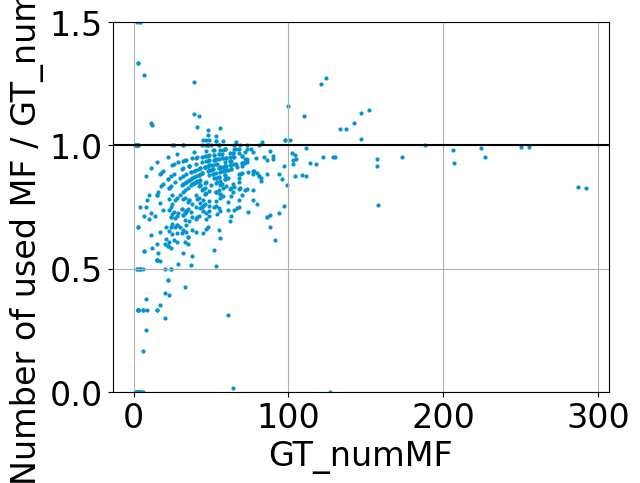

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/1993538496.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bouton_vol_sorted2 = np.array(bouton_vol_sorted)
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/1993538496.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(gt_numMF_sorted_filtered, bouton_vol_mean_filtered, s=24, c=peacock)


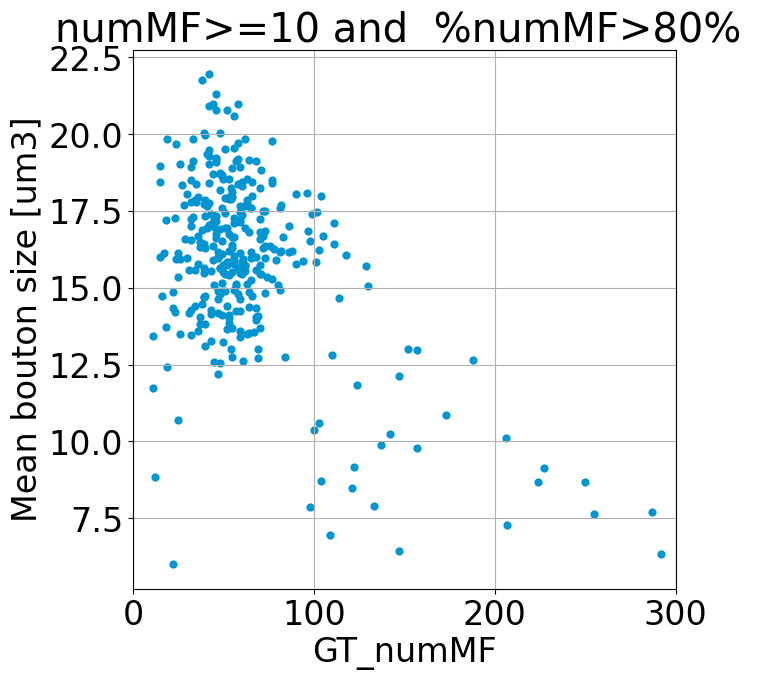

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/1993538496.py:71: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(gt_numMF_extended, bouton_size_extended, s=3, c=peacock, alpha=0.32)


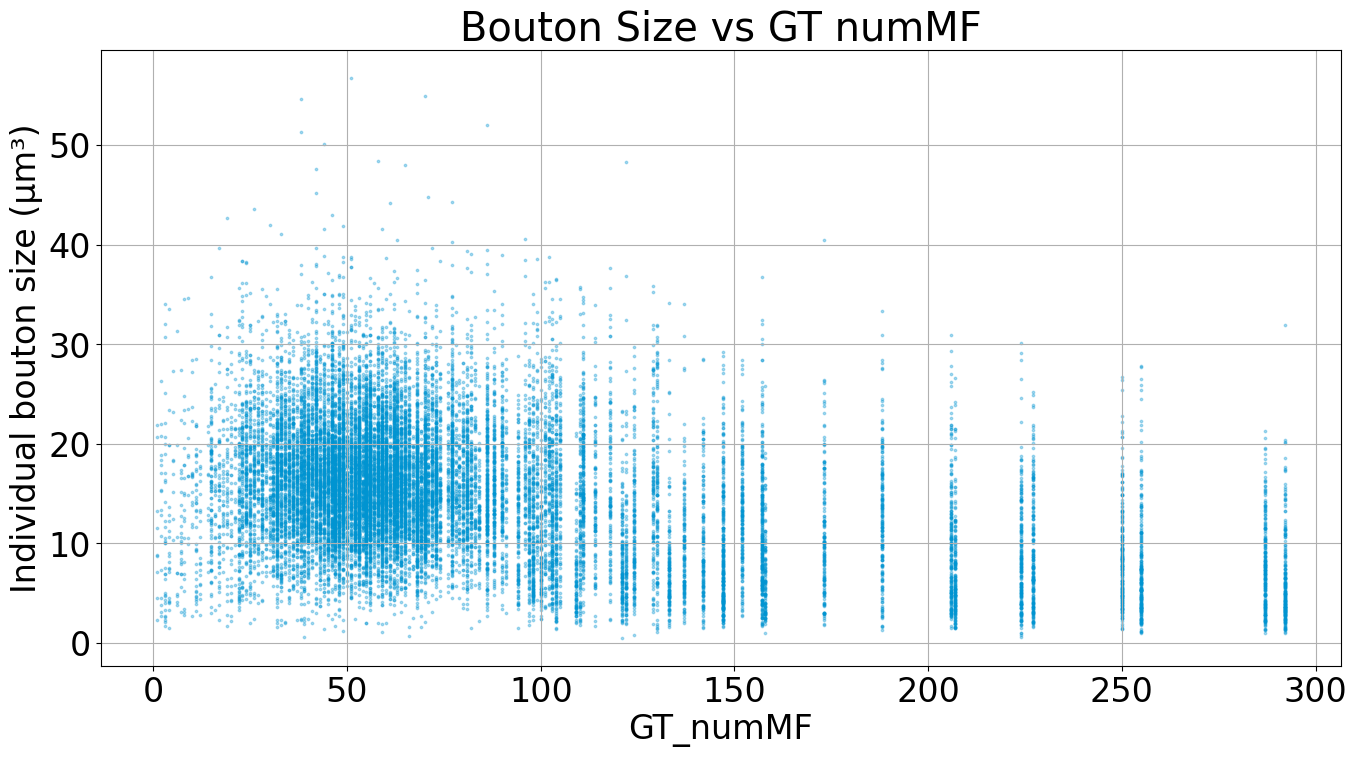

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/1993538496.py:79: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.log10(gt_numMF_extended), bouton_size_extended, s=4, c=peacock, alpha=0.32)


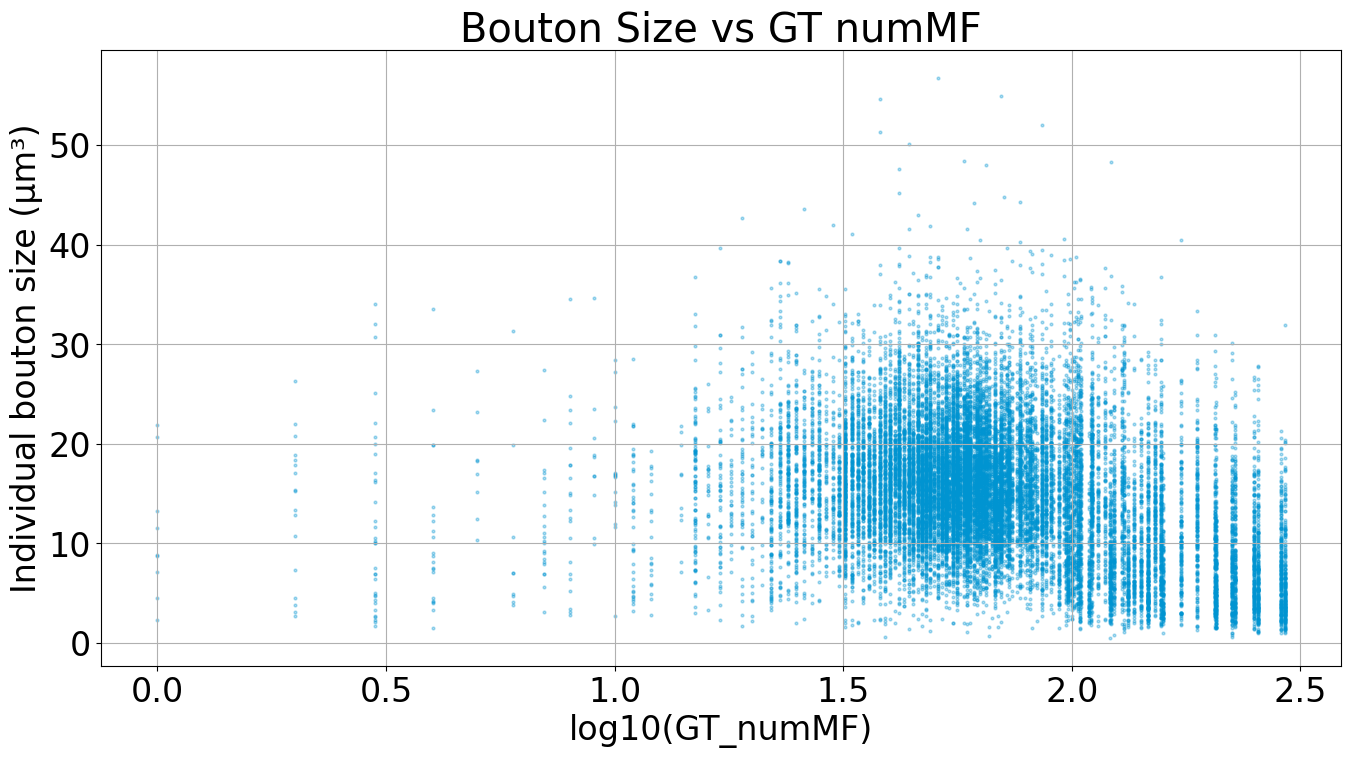

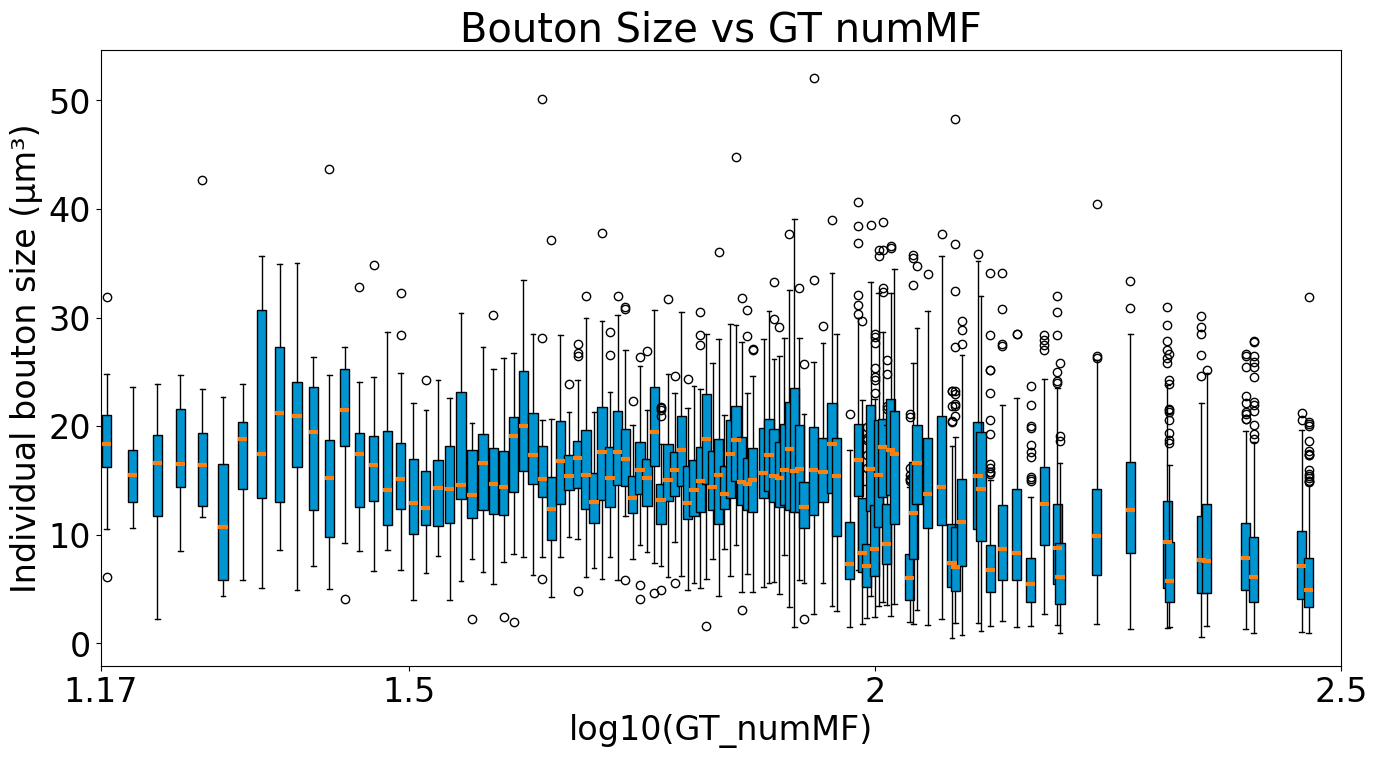

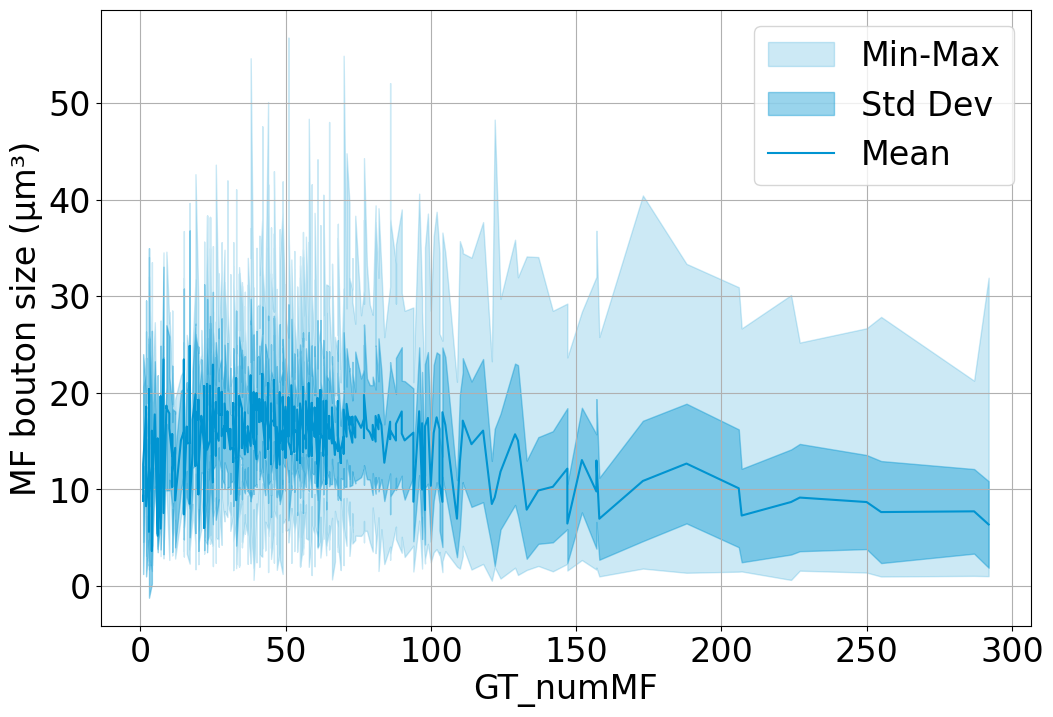

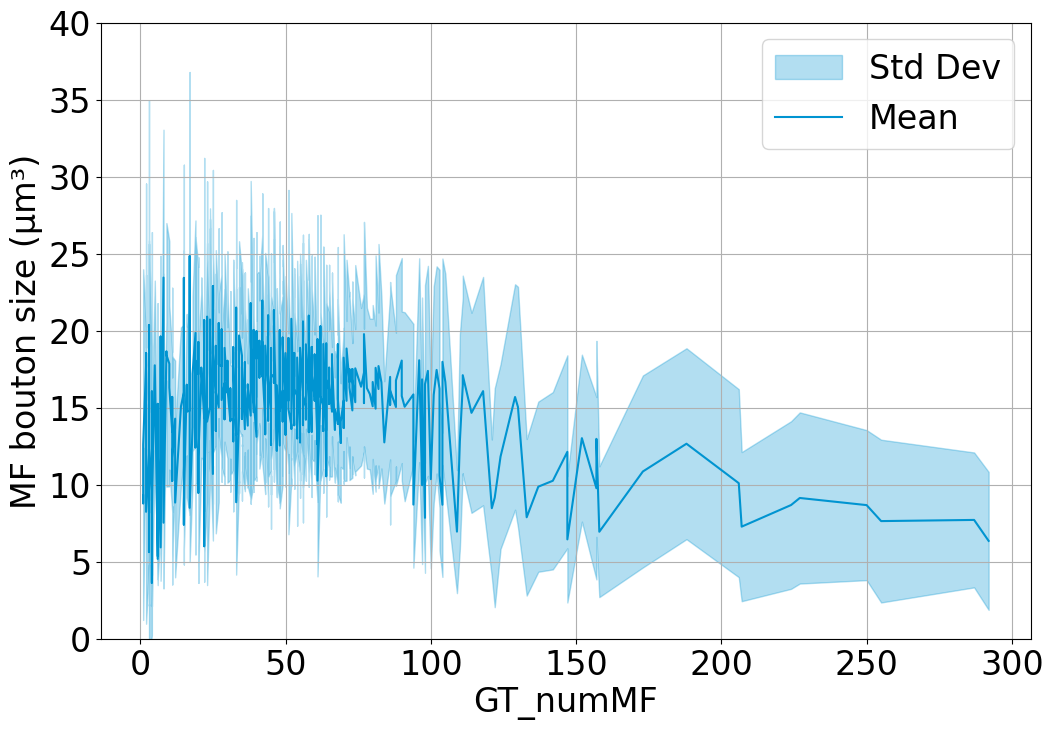

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/1993538496.py:162: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(gt_numMF_sorted2, list_sum2, s=24, c=peacock)


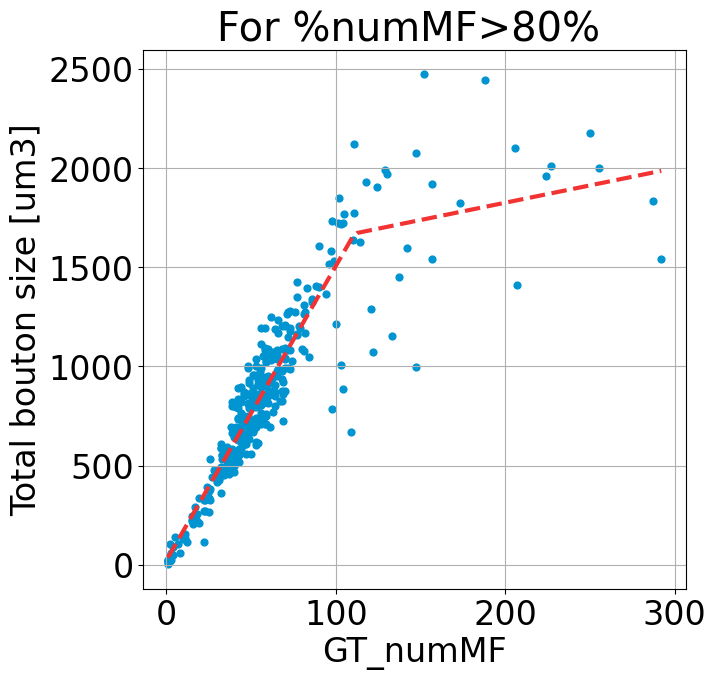

In [339]:
import pwlf
import statistics

bouton_vol_sorted = [a for a,b in zip(bouton_vol_sorted, gt_numMF_sorted) if b !=0]
used_preMF_sorted = [a for a,b in zip(used_preMF_sorted, gt_numMF_sorted) if b !=0]
gt_numMF_sorted = [b for b in gt_numMF_sorted if b!= 0]


list_len = [len(item) for item in used_preMF_sorted]
#print(list_len)
#print(gt_numMF_sorted_filtered)
res = np.array(list_len) / np.array(gt_numMF_sorted)
#res2 = res[mask]
res3 = res[~np.isnan(res) & ~np.isinf(res)]
#lt.rcParams.update({'font.size': 14})
plt.scatter(gt_numMF_sorted, res, s=4, c=peacock)
plt.ylim([0,1.5])
plt.axhline(y=1, color='k')
plt.xlabel("GT_numMF")
plt.ylabel("Number of used MF / GT_numMF ")
plt.grid(True)
plt.show()


# Filter out data if more than 20% of pre-MFs are missing.
mask = res >= 0.8
gt_numMF_sorted2 = np.array(gt_numMF_sorted)
gt_numMF_sorted2 = gt_numMF_sorted2[mask]
bouton_vol_sorted2 = np.array(bouton_vol_sorted)
bouton_vol_sorted2 = bouton_vol_sorted2[mask]

plt.rcParams.update({'font.size': 24})
f, ax = plt.subplots(1,1, figsize=(7,7))
idx_many_bouton = [i for i, sublist in enumerate(bouton_vol_sorted2) if len(sublist)>=10]
bouton_vol_mean = [sum(sublist) / len(sublist) if sublist else None for sublist in bouton_vol_sorted2]
bouton_vol_mean_filtered = [bouton_vol_mean[i] for i in idx_many_bouton]
gt_numMF_sorted_filtered = [gt_numMF_sorted2[i] for i in idx_many_bouton]
plt.scatter(gt_numMF_sorted_filtered, bouton_vol_mean_filtered, s=24, c=peacock)
plt.xlabel("GT_numMF")
plt.ylabel("Mean bouton size [um3]")
plt.title("numMF>=10 and  %numMF>80% ")
plt.xlim([0,300])
plt.grid(True)
plt.show()

# scatter
bouton_vol_sorted_filtered = bouton_vol_sorted
gt_numMF_sorted_filtered = gt_numMF_sorted
gt_numMF_extended = []
bouton_size_extended = []
bouton_size_stds = []
bouton_size_means = []
bouton_size_mins = []
bouton_size_maxs = []
gt_numMF_ribbon = []
mf_group_id = []
f, ax = plt.subplots(1,1, figsize=(16,8))
for i in range(len(gt_numMF_sorted_filtered)):
    bouton_size_extended.extend(bouton_vol_sorted_filtered[i])
    gt_numMF_extended.extend([gt_numMF_sorted_filtered[i]] * len(bouton_vol_sorted_filtered[i]))
    mf_group_id.extend([i] * len(bouton_vol_sorted_filtered[i]))
    
    if len(bouton_vol_sorted_filtered[i]) > 1:
        bouton_size_stds.append(statistics.stdev(bouton_vol_sorted_filtered[i]))
        bouton_size_means.append(statistics.mean(bouton_vol_sorted_filtered[i]))
        bouton_size_mins.append(min(bouton_vol_sorted_filtered[i]))
        bouton_size_maxs.append(max(bouton_vol_sorted_filtered[i]))
        gt_numMF_ribbon.append(gt_numMF_sorted_filtered[i])

        
plt.scatter(gt_numMF_extended, bouton_size_extended, s=3, c=peacock, alpha=0.32)
plt.xlabel("GT_numMF")
plt.ylabel("Individual bouton size (\u03bcm\u00b3)")
plt.title("Bouton Size vs GT numMF")
plt.grid(True)
plt.show()    
        
f, ax = plt.subplots(1,1, figsize=(16,8))    
plt.scatter(np.log10(gt_numMF_extended), bouton_size_extended, s=4, c=peacock, alpha=0.32)
plt.xlabel("log10(GT_numMF)")
plt.ylabel("Individual bouton size (\u03bcm\u00b3)")
plt.title("Bouton Size vs GT numMF")
plt.grid(True)
plt.show()


# box-whisker log plot
f, ax = plt.subplots(1,1, figsize=(16,8))    
df_temp = pd.DataFrame({'x': (np.log10(gt_numMF_extended)), 'y':bouton_size_extended, 'id':mf_group_id})
#grouped_x = df_temp.groupby('x')['y'].apply(list)
#plt.boxplot(grouped_x.tolist(),positions=grouped_x.index.tolist(), widths=0.01)
grouped_id = df_temp.groupby('id')
bw_positions = []
bw_data = []

def select_random_id(group):
    selected_id = random.choice(group['id'].unique())
    return group[group['id'] == selected_id]
df_temp_one_box_per_x = df_temp.groupby('x', group_keys=False).apply(select_random_id)
grouped_id = df_temp_one_box_per_x.groupby('id')

for _, group in grouped_id:
    
    x_val = group['x'].iloc[0]
    bw_positions.append(x_val)
    bw_data.append(group['y'].values)
box = plt.boxplot(bw_data,positions=bw_positions, widths=0.01, patch_artist=True)
my_x_ticks = [1.17,1.5,2,2.5]
for median in box['medians']:
#    median.set_color('red')
    median.set_linewidth(3)
    
for patch in box['boxes']:
    patch.set_facecolor(peacock)
    patch.set_edgecolor('black')
    patch.set_linewidth(1)
plt.xticks(my_x_ticks, my_x_ticks)
plt.xlabel("log10(GT_numMF)")
plt.ylabel("Individual bouton size (\u03bcm\u00b3)")
plt.title("Bouton Size vs GT numMF")
plt.xlim([1.17,2.5])
plt.show()


# ribbon plot
plt.figure(figsize=(12, 8))
plt.fill_between(gt_numMF_ribbon, np.array(bouton_size_mins), np.array(bouton_size_maxs), color=peacock, alpha=0.2, label="Min-Max")
plt.fill_between(gt_numMF_ribbon, np.array(bouton_size_means) - np.array(bouton_size_stds), np.array(bouton_size_means) + np.array(bouton_size_stds), color=peacock, alpha=0.4, label="Std Dev")
plt.plot(gt_numMF_ribbon, bouton_size_means, color=peacock, label="Mean")
plt.xlabel("GT_numMF")
plt.ylabel("MF bouton size (\u03bcm\u00b3)")
plt.legend()
plt.grid(True)
#plt.ylim([0,40])
plt.show()


# ribbon plot
plt.figure(figsize=(12, 8))
#plt.fill_between(gt_numMF_ribbon, np.array(bouton_size_mins), np.array(bouton_size_maxs), color=peacock, alpha=0.2, label="Min-Max")
plt.fill_between(gt_numMF_ribbon, np.array(bouton_size_means) - np.array(bouton_size_stds), np.array(bouton_size_means) + np.array(bouton_size_stds), color=peacock, alpha=0.3, label="Std Dev")
plt.plot(gt_numMF_ribbon, bouton_size_means, color=peacock, label="Mean")
plt.xlabel("GT_numMF")
plt.ylabel("MF bouton size (\u03bcm\u00b3)")
plt.legend()
plt.grid(True)
plt.ylim([0,40])
plt.show()


list_sum2 = np.array([sum(item) for item in bouton_vol_sorted2])
coeff = np.polyfit(gt_numMF_sorted2,list_sum2,2)
poly = np.poly1d(coeff)
y_fitted = poly(gt_numMF_sorted2)
pwlf_model = pwlf.PiecewiseLinFit(gt_numMF_sorted2,list_sum2)
breakpoints = pwlf_model.fit(2)
x_hat = np.linspace(min(gt_numMF_sorted2), max(gt_numMF_sorted2), 100)
y_hat = pwlf_model.predict(x_hat)

f, ax = plt.subplots(1,1, figsize=(7,7))
plt.rcParams.update({'font.size': 24})
plt.scatter(gt_numMF_sorted2, list_sum2, s=24, c=peacock)
plt.plot(x_hat, y_hat, color=coral, linewidth=3, linestyle='--')
plt.xlabel("GT_numMF")
plt.ylabel("Total bouton size [um3]")
plt.title("For %numMF>80% ")
plt.grid(True)
plt.show()



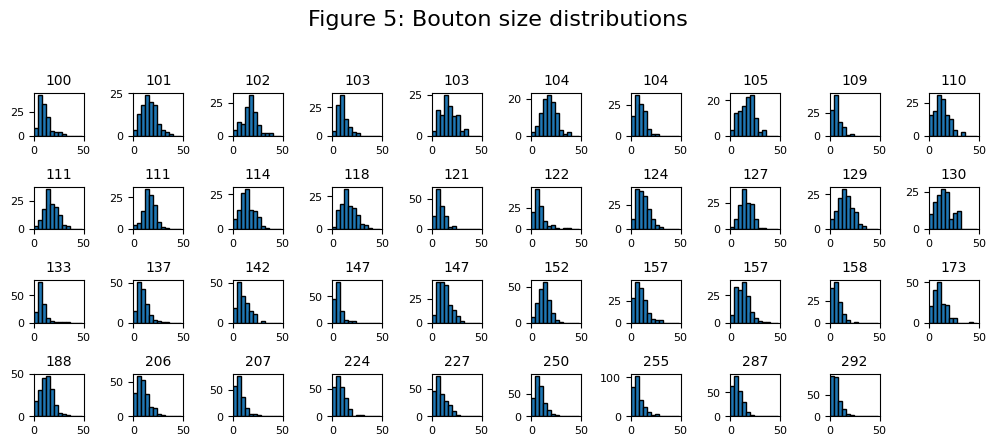

In [405]:

def plot_histograms(A, start_idx, end_idx, bins, fig_num):
    plt.rcParams.update({'font.size': 8})
    plt.figure(figsize=(10, 10))  
    for i, sublist in enumerate(A[start_idx:end_idx]):
        plt.subplot(10, 10, i + 1)
        plt.xlim([0,50])
        plt.hist(sublist, bins=bins, edgecolor='black')
        plt.title(f"{gt_numMF_sorted[i+start_idx]}", fontsize=10)
    plt.suptitle(f"Figure {fig_num}: Bouton size distributions", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Prevent title overlap

bins = np.arange(0,50,4)
plot_histograms(bouton_vol_sorted, 600, 700,bins, 5)


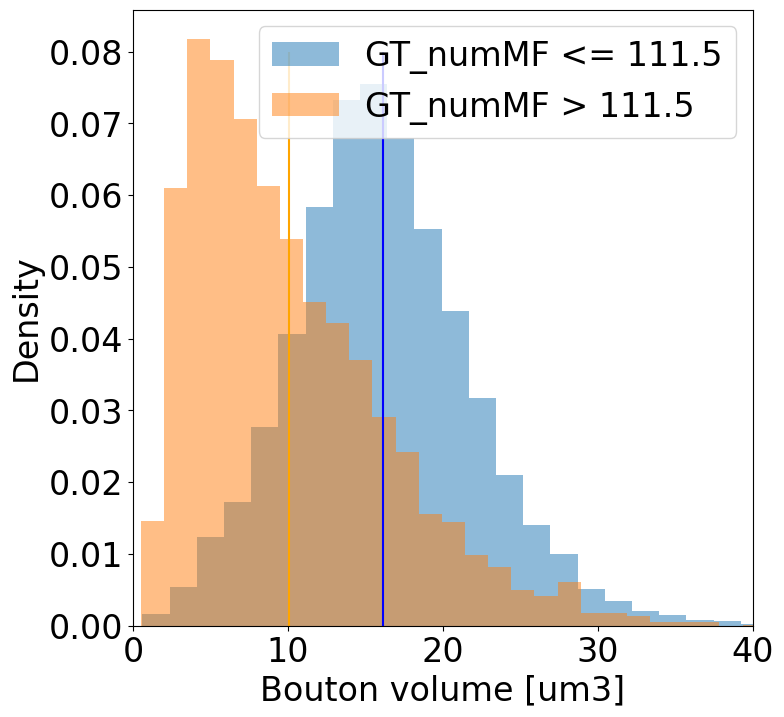

In [66]:
idx_separate = next((i for i, x in enumerate(gt_numMF_sorted2) if x > 111.5), -1)
bouton_vol_few_mf = bouton_vol_sorted2[0:idx_separate]
bouton_vol_many_mf = bouton_vol_sorted2[idx_separate:]

bouton_vol_few_mf_list = [num for sublist in bouton_vol_few_mf for num in sublist]
bouton_vol_many_mf_list = [num for sublist in bouton_vol_many_mf for num in sublist]


f, ax = plt.subplots(1,1, figsize=(8,8))
plt.rcParams.update({'font.size': 24})
plt.hist(bouton_vol_few_mf_list, bins=32, alpha=0.5, density=True, label='GT_numMF <= 111.5')
plt.hist(bouton_vol_many_mf_list, bins=32, alpha=0.5, density=True, label='GT_numMF > 111.5')

plt.xlabel('Bouton volume [um3]')
plt.ylabel('Density')
plt.legend()
plt.xlim([0,40])
plt.vlines(sum(bouton_vol_few_mf_list)/len(bouton_vol_few_mf_list), 0, 0.08, colors='blue')
plt.vlines(sum(bouton_vol_many_mf_list)/len(bouton_vol_many_mf_list), 0, 0.08, colors='orange')
#plt.title("Bouton Size Partial Result. N(blue)=10573, N(orange)=648")


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/4158923632.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_data_filt[::nth_elem],y_data_filt[::nth_elem] , s=8, c=peacock)


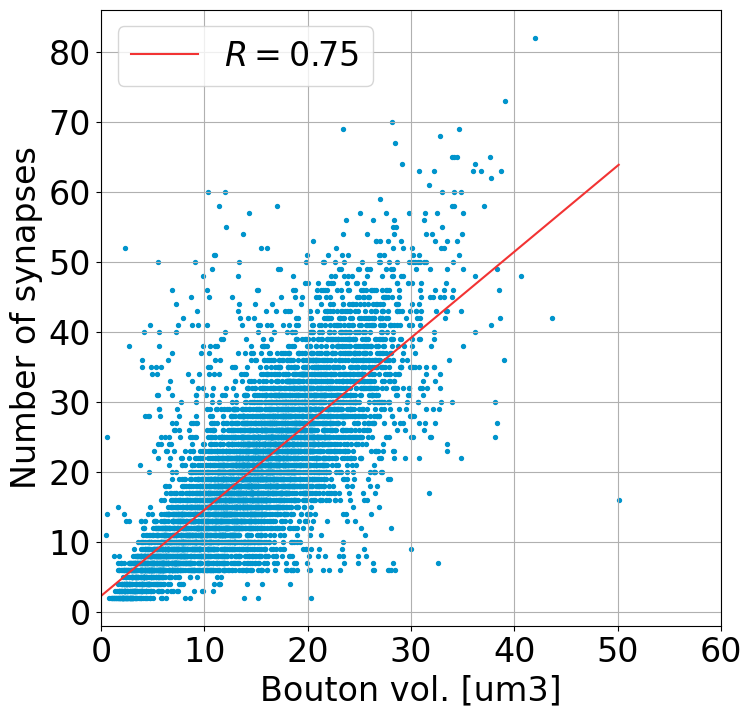

In [65]:
# bouton size is correlated with number of synapses

#print((bouton_info))

from scipy.stats import linregress

plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 24})
x_data=bouton_info['bouton_vol_um3'].values
y_data=bouton_info['numsyn'].values
x_data_filt = [x for x in x_data if x != 0]
y_data_filt = [y for x,y in zip(x_data,y_data) if x!=0]
nth_elem = 3

m,b,r_val,_,_ = linregress(x_data_filt[::nth_elem],y_data_filt[::nth_elem])
xx = np.linspace(0,max(x_data_filt[::nth_elem]),100)
y_pred = m*xx +b
plt.scatter(x_data_filt[::nth_elem],y_data_filt[::nth_elem] , s=8, c=peacock)
plt.xlim([0,60])
#plt.axhline(y=1, color='k')
plt.plot(xx, y_pred, color=coral, label=f"$R={r_val:.2f}$")
plt.xlabel("Bouton vol. [um3]")
plt.ylabel("Number of synapses")
plt.grid(True)
plt.legend()
plt.show()



In [42]:
bouton_info_sorted = bouton_info.sort_values(by='bouton_vol_um3', ascending=True)
#print(bouton_info_sorted)
print(bouton_info_sorted.head(5))


             nbouton           pre_mf_id         post_pyc_id  \
14314  single_bouton  648518346423415464  648518346442105605   
7591   single_bouton  648518346380967407  648518346428505059   
24228  double_bouton  648518346451396923  648518346442574364   
23187  double_bouton  648518346447980193  648518346437937024   
12735  single_bouton  648518346476436134  648518346446683356   

                                   syn_cluster_center_vx  numsyn  \
14314  [34499.421052631566, 68635.68421052632, 726.15...      19   
7591   [36836.57142857143, 65860.92857142858, 1330.85...      14   
24228  [36367.222222222226, 62015.55555555554, 694.66...      28   
23187  [46065.399999999994, 57124.13333333333, 1250.3...      25   
12735  [58987.36363636364, 67551.99999999999, 681.909...      11   

       bouton_vol_um3                                         bouton_bbx  \
14314          0.1182  Bbox([34455, 68601, 736],[34550, 68678, 760], ...   
7591           0.1259  Bbox([36805, 65790, 1303],[3686

In [54]:
bouton_info_sorted = bouton_info.sort_values(by='bouton_vol_um3', ascending=True)
bouton_info_sorted2 = bouton_info_sorted[bouton_info_sorted['numsyn'] > 4]
bouton_info_sorted3 = bouton_info_sorted2[100:]


In [56]:
# generate 2D bouton images for randomly selected cells (grouped by size)

size_bins = [x for x in range(0,60,5)]
bbx = vol.bounds
num_panel = 30

for i in range(0, 2):
#for i in range(0, len(size_bins)-1):
    edge1 = size_bins[i]
    edge2 = size_bins[i+1]
    this_bouton_info = bouton_info_sorted3[(bouton_info_sorted3['bouton_vol_um3'] > edge1) & (bouton_info_sorted3['bouton_vol_um3'] < edge2)]

    mf_ids = this_bouton_info['pre_mf_id'].values
    pc_ids = this_bouton_info['post_pyc_id'].values
    
    np.random.seed(i+3)
    idx_rand = np.random.choice(len(mf_ids), min(50, len(mf_ids)), replace=False)
    mf_ids_rand = [mf_ids[i] for i in idx_rand]
    pc_ids_rand = [pc_ids[i] for i in idx_rand]
    
    f, ax = plt.subplots(6,5, figsize=(12,12))
    panel = 0
    for j in range(0, len(mf_ids_rand)):
    
        mf_id_latest = client.chunkedgraph.suggest_latest_roots(mf_ids_rand[j])
        pc_id_latest = client.chunkedgraph.suggest_latest_roots(pc_ids_rand[j])
        syn_center = this_bouton_info['syn_cluster_center'].values[j]
        numsyn = this_bouton_info['numsyn'].values[j]
        try:
            result = split_selected_bouton_for_figure(mf_id_latest, pc_id_latest, vol,client)
        except:
            continue
        if result != None:
            group1 = result[4]
            group2 = result[5]
            group3 = result[6]
            bbx = result[7]
            ax = ax.flatten()
            ax[panel].scatter(group2[:,0], group2[:,1], c='blue')
            ax[panel].scatter(group3[:,0], group3[:,1], c='blue')
            ax[panel].scatter(group1[:,0], group1[:,1], c='red')
            ax[panel].set_aspect('equal')
            ax[panel].axis('off')
            ax[panel].set_ylim(bbx.minpt.y * 18, bbx.maxpt.y * 18)
            ax[panel].set_xlim(bbx.minpt.x * 18, bbx.maxpt.x * 18)
            print(i,j)
            panel += 1
        if panel >= num_panel:
            break
        
    plt.suptitle('Boutons of size '+  str(edge1) + '-' + str(edge2)+ 'um3')
    plt.savefig('./result/bouton_split/bouton_sampled_by_size/'+'Boutons of size '+ str(edge1) + '-'+ str(edge2))
    plt.close()    
    
    
    
    
    
    


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29


In [61]:
# generate 2D bouton images for smallest and largest ones

num_panel = 30

#this_bouton_info = bouton_info_sorted3.head(30)
this_bouton_info = bouton_info_sorted3.tail(30)
                                        
mf_ids = this_bouton_info['pre_mf_id'].values
pc_ids = this_bouton_info['post_pyc_id'].values

f, ax = plt.subplots(6,5, figsize=(12,12))
panel = 0
for j in range(0, len(mf_ids_rand)):

    mf_id_latest = client.chunkedgraph.suggest_latest_roots(mf_ids[j])
    pc_id_latest = client.chunkedgraph.suggest_latest_roots(pc_ids[j])
    syn_center = this_bouton_info['syn_cluster_center'].values[j]
    numsyn = this_bouton_info['numsyn'].values[j]
    try:
        result = split_selected_bouton_for_figure(mf_id_latest, pc_id_latest, vol,client)
    except:
        continue
    if result != None:
        group1 = result[4]
        group2 = result[5]
        group3 = result[6]
        bbx = result[7]
        ax = ax.flatten()
        ax[panel].scatter(group2[:,0], group2[:,1], c='blue')
        ax[panel].scatter(group3[:,0], group3[:,1], c='blue')
        ax[panel].scatter(group1[:,0], group1[:,1], c='red')
        ax[panel].set_aspect('equal')
        ax[panel].axis('off')
        ax[panel].set_ylim(bbx.minpt.y * 18, bbx.maxpt.y * 18)
        ax[panel].set_xlim(bbx.minpt.x * 18, bbx.maxpt.x * 18)
        print(i,j)
        panel += 1
    if panel >= num_panel:
        break

plt.suptitle('largest boutons')
plt.savefig('./result/bouton_split/bouton_sampled_by_size/largest_boutons')
plt.close()    
    

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_9942/11239621.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_curve2,y_curve2,s=10,c=[1,0.15,0.15],marker='o')


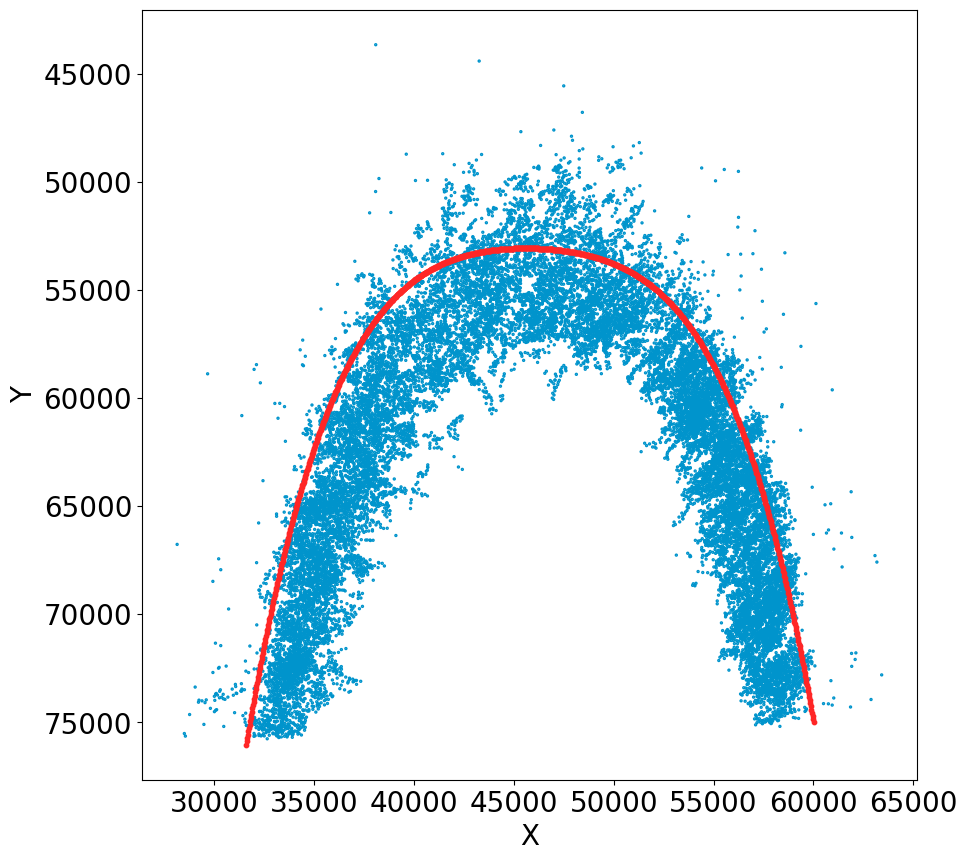

In [64]:
with open("./variables/layer_boundary_equations.pkl", 'rb') as f:
    x_curve1, y_curve1, x_curve2, y_curve2, x_curve3, y_curve3 = pickle.load(f)


bouton_coord = bouton_info['syn_cluster_center_vx'].values
bx = [item[0] for item in bouton_coord]
by = [item[1] for item in bouton_coord]
bouton_vols = bouton_info['bouton_vol_um3'].values
plt.figure(figsize=(10, 10))  
plt.rcParams.update({'font.size': 20})
plt.scatter(bx, by, s=2, facecolors="None", edgecolors=peacock,)
#plt.scatter(x_curve1,y_curve1,s=10,c=[0.8,0.3,0.8],marker='o')
plt.scatter(x_curve2,y_curve2,s=10,c=[1,0.15,0.15],marker='o')
#plt.scatter(x_curve3,y_curve3,s=10,c=[0.3,0.25,0.3],marker='o')
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()
#plt.axis('off')
plt.show()

In [66]:
# Find all pairs of boutons from the same MF, and see if their size are correlated (like spine size)

from itertools import combinations

pair_idx = []
for _, group in bouton_info.groupby('pre_mf_id'):
    if len(group) > 1:
        indices = group.index.tolist()
        pair_idx.extend(list(combinations(indices,2)))
        
pairs = [(bouton_info['bouton_vol_um3'].loc[i], bouton_info['bouton_vol_um3'].loc[j]) for i,j in pair_idx]
print(pairs)

[(12.6755, 12.6755), (10.4984, 10.4984), (23.0053, 23.0053), (4.5594, 4.5594), (11.0887, 11.0887), (23.8651, 23.8651), (39.1564, 39.1564)]


In [175]:
uniquemf = bouton_info['pre_mf_id'].unique()
print(len(uniquemf))

12925


In [67]:
# Get all MF latest roots

gc = pygsheets.authorize(service_file = "./hippca3-8126bea0d603.json")
sheet = gc.open('CA3 proofreading')
worksheet = sheet.worksheet('title','4.MFunique_611#1')
worksheet2 = sheet.worksheet('title','12.additional_MF')
mf_df = worksheet.get_as_df(start='A4')
mf_df2 = worksheet2.get_as_df(start='A8')
mf_df['presyn_position'] = mf_df['presyn_position'].apply(lambda x: list(map(int, ast.literal_eval(x))))
mf_df2['pre_pt_position (Coords)'] = mf_df2['pre_pt_position (Coords)'].apply(lambda x: list(map(int, ast.literal_eval(x))))

latest_mf1 = []latest_mf2 = []

pre_coord_in_vol = np.array(mf_df['presyn_position'].to_list())
cell_ids_scatter = vol.scattered_points(pre_coord_in_vol)
for i in range(0, len(pre_coord_in_vol)):
    if i % 100 == 0:
        print(i)
    cell_ID = [cell_ids_scatter.get(tuple(pre_coord_in_vol[i,:]))]
    if cell_ID[0] == 0:
        print("Failed to find neuron segment ID using nuclei center")
    else:
        latest_mf1.append(cell_ID[0])

        
pre_coord_in_vol = np.array(mf_df2['pre_pt_position (Coords)'].to_list())
cell_ids_scatter = vol.scattered_points(pre_coord_in_vol)
for i in range(0, len(pre_coord_in_vol)):
    if i % 100 == 0:
        print(i)
    cell_ID = [cell_ids_scatter.get(tuple(pre_coord_in_vol[i,:]))]
    if cell_ID[0] == 0:
        print("Failed to find neuron segment ID using nuclei center")
    else:
        latest_mf2.append(cell_ID[0])
        
latest_mf1_str = [str(num) for num in latest_mf1]
latest_mf2_str = [str(num) for num in latest_mf2]

indices_not_mf1 = mf_df.index[mf_df['Mossy Fiber?'] == 'No'].tolist()
indices_not_mf2 = mf_df2.index[mf_df2['Status'] != 'Done'].tolist()
latest_mf1_filtered = [elem for idx, elem in enumerate(latest_mf1) if idx not in indices_not_mf1]
latest_mf2_filtered = [elem for idx, elem in enumerate(latest_mf2) if idx not in indices_not_mf2]

latest_roots_mf = list(set(latest_mf1_filtered + latest_mf2_filtered))
print(len(latest_roots_mf))



/opt/anaconda3/envs/allensdk/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')
Downloading: 100%|█████████████████████████████████████████████████████████████████| 10797/10797 [02:49<00:00, 63.55it/s]


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700


Downloading: 100%|█████████████████████████████████████████████████████████████████| 16963/16963 [04:49<00:00, 58.65it/s]


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
26050


In [187]:
# distribution of numsyn MF-Pyr

syn_counts = []
for i in range(0, len(latest_roots_mf)//100):
    syn = client.materialize.synapse_query(pre_ids=latest_roots_mf[i*100:(i+1)*100], post_ids=latest_roots_PC, bounding_box=None, bounding_box_column='post_pt_position', 
                            timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                            split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                            synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
    syn_grouped = {key: group for key, group in syn.groupby('pre_pt_root_id')}
    for syn_same_mf in syn_grouped.values():
        
        count = syn_same_mf.groupby('post_pt_root_id').size()
        syn_counts += list(count.values)
    if i % 50 == 0:
        print(i)
print('Done')

0
50
100
150
200
250
Done


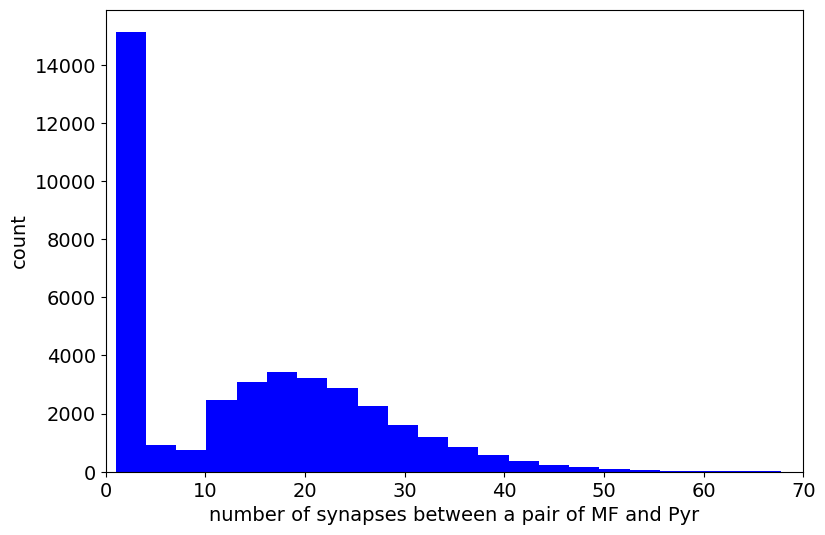

In [199]:
# draw distribution of numsyn MF-pyr
plt.figure(figsize=(9,6))
plt.hist(syn_counts, bins=30, color='blue')
plt.xlabel('number of synapses between a pair of MF and Pyr')
plt.ylabel('count')
plt.xlim([0,70])
plt.show()

In [197]:
syn_counts_filtered = [x for x in syn_counts if x >=5]
print(len(syn_counts_filtered))
print(len(syn_counts_filtered)/len(latest_roots_mf))

24231
0.9301727447216891


In [207]:
# Find all pairs of synapse size from the same MF, since it's correlated with bouton size
from itertools import combinations

syn_size_pairs3 = []
syn_size_pairs5 = []
syn_size_pairs10 = []
mf_with_many_targets = []


#for i in range(0, 1):
for i in range(0, len(latest_roots_mf)//100):
    syn = client.materialize.synapse_query(pre_ids=latest_roots_mf[i*100:(i+1)*100], post_ids=latest_roots_PC, bounding_box=None, bounding_box_column='post_pt_position', 
                            timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                            split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                            synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
    syn_grouped = {key: group for key, group in syn.groupby('pre_pt_root_id')}
    for syn_same_mf in syn_grouped.values():
        
        syn_filtered = syn_same_mf.groupby('post_pt_root_id').filter(lambda group: len(group) >= 3)
        this_mf_syn = syn_filtered.groupby('post_pt_root_id')['size'].sum().reset_index()
        if len(this_mf_syn) > 1:
            pairs = list(combinations(this_mf_syn['size'],2))
            syn_size_pairs3 += pairs

        syn_filtered = syn_same_mf.groupby('post_pt_root_id').filter(lambda group: len(group) >= 5)
        this_mf_syn = syn_filtered.groupby('post_pt_root_id')['size'].sum().reset_index()
        if len(this_mf_syn) > 1:
            pairs = list(combinations(this_mf_syn['size'],2))
            syn_size_pairs5 += pairs
            
        syn_filtered = syn_same_mf.groupby('post_pt_root_id').filter(lambda group: len(group) >= 10)
        this_mf_syn = syn_filtered.groupby('post_pt_root_id')['size'].sum().reset_index()
        if len(this_mf_syn) > 1:
            pairs = list(combinations(this_mf_syn['size'],2))
            syn_size_pairs10 += pairs
            mf_with_many_targets.append(syn_same_mf['pre_pt_root_id'].values[0])
            
    if i % 25 == 0:
        print(i)
    
print('Done')

0
25


KeyboardInterrupt: 

5997
4133
3191


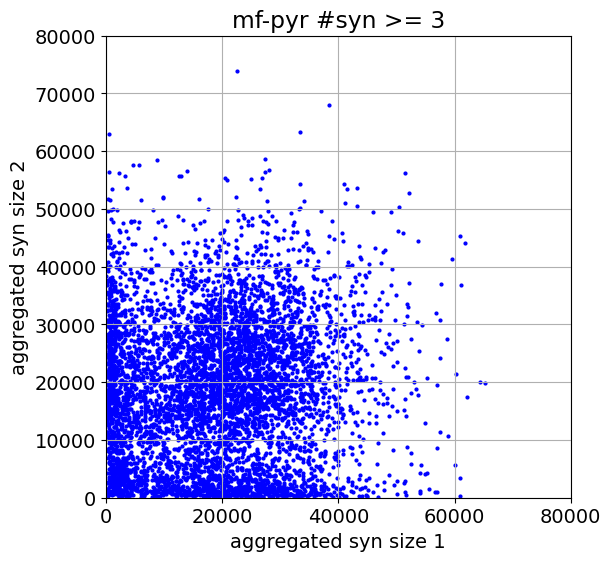

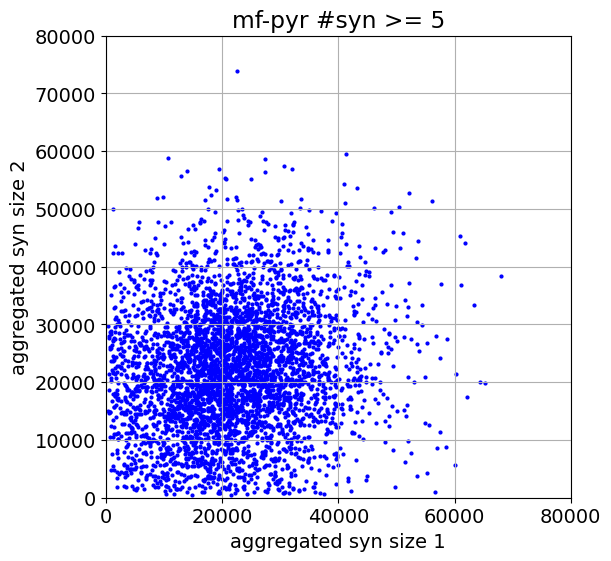

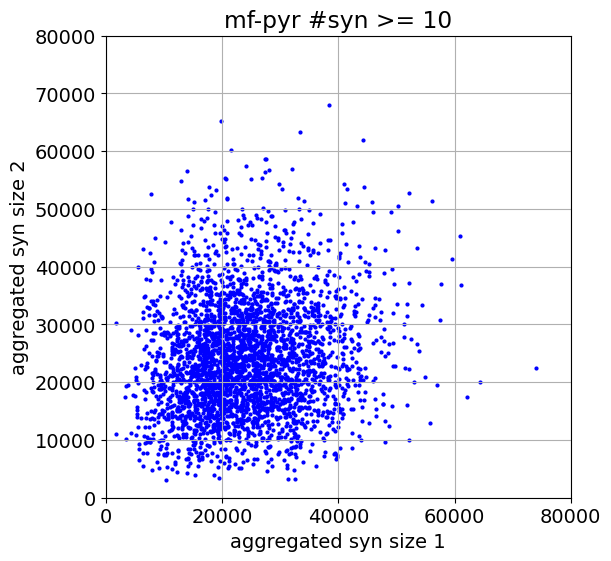

In [200]:
# scatter plot syn size vs syn size

import random
print(len(syn_size_pairs3))
print(len(syn_size_pairs5))
print(len(syn_size_pairs10))

indices_to_swap_xy3 = random.sample(range(len(syn_size_pairs3)), len(syn_size_pairs3)//2)
indices_to_swap_xy5 = random.sample(range(len(syn_size_pairs5)), len(syn_size_pairs5)//2)
indices_to_swap_xy10 = random.sample(range(len(syn_size_pairs10)), len(syn_size_pairs10)//2)

for idx in indices_to_swap_xy3:
    x,y = syn_size_pairs3[idx]
    syn_size_pairs3[idx] = (y,x)
for idx in indices_to_swap_xy5:
    x,y = syn_size_pairs5[idx]
    syn_size_pairs5[idx] = (y,x)    
for idx in indices_to_swap_xy10:
    x,y = syn_size_pairs10[idx]
    syn_size_pairs10[idx] = (y,x)
    
xc3, yc3 = zip(*syn_size_pairs3)
xc5, yc5 = zip(*syn_size_pairs5)
xc10, yc10 = zip(*syn_size_pairs10)

plt.figure(figsize=(6,6))
plt.scatter(xc3, yc3, color='blue', s=4)
plt.xlabel('aggregated syn size 1')
plt.ylabel('aggregated syn size 2')
plt.title('mf-pyr #syn >= 3')
plt.xlim([0,80000])
plt.ylim([0,80000])
plt.grid(True)
plt.show()

xc5, yc5 = zip(*syn_size_pairs5)
plt.figure(figsize=(6,6))
plt.scatter(xc5, yc5, color='blue', s=4)
plt.xlabel('aggregated syn size 1')
plt.ylabel('aggregated syn size 2')
plt.title('mf-pyr #syn >= 5')
plt.xlim([0,80000])
plt.ylim([0,80000])
plt.grid(True)
plt.show()

xc10, yc10 = zip(*syn_size_pairs10)
plt.figure(figsize=(6,6))
plt.scatter(xc10, yc10, color='blue', s=4)
plt.xlabel('aggregated syn size 1')
plt.ylabel('aggregated syn size 2')
plt.title('mf-pyr #syn >= 10')
plt.xlim([0,80000])
plt.ylim([0,80000])
plt.grid(True)
plt.show()

In [219]:
# load latest roots:
file_path = './variables/latest_mf_roots_grouped_by_target_pc.pkl'
with open(file_path, 'rb') as f:
    latest_roots_mf_group = pickle.load(f)
    
file_path = './variables/latest_pc_roots_grouped_by_target_pc.pkl'
with open(file_path, 'rb') as f:
    latest_roots_PC_gt = pickle.load(f)

In [220]:
from itertools import chain
print(len(latest_roots_mf_group))
latest_roots_mf_group_flattened = list(chain.from_iterable(latest_roots_mf_group))
latest_roots_mf_group_flattened = list(filter(lambda x: x is not None, latest_roots_mf_group_flattened))
unique_latest_roots_gt_mf = np.unique(latest_roots_mf_group_flattened)
print(len(unique_latest_roots_gt_mf))

650
23818


0
50
100
150
200
Done


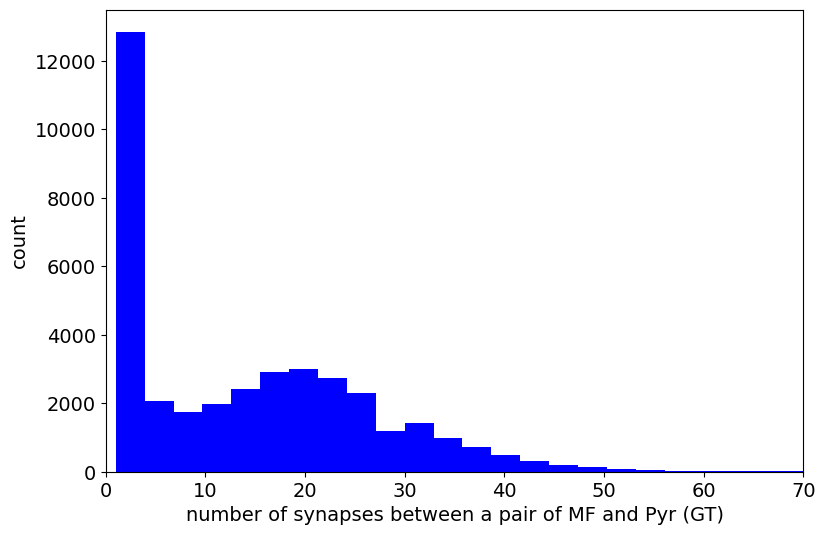

In [221]:
# distribution of numsyn GT MF-Pyr

syn_counts = []
for i in range(0, len(unique_latest_roots_gt_mf)//100):
    syn = client.materialize.synapse_query(pre_ids=unique_latest_roots_gt_mf[i*100:(i+1)*100], post_ids=latest_roots_PC_gt, bounding_box=None, bounding_box_column='post_pt_position', 
                            timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                            split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                            synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
    syn_grouped = {key: group for key, group in syn.groupby('pre_pt_root_id')}
    for syn_same_mf in syn_grouped.values():
        
        count = syn_same_mf.groupby('post_pt_root_id').size()
        syn_counts += list(count.values)
    if i % 50 == 0:
        print(i)
print('Done')

# draw distribution of numsyn GT MF-pyr
plt.figure(figsize=(9,6))
plt.hist(syn_counts, bins=30, color='blue')
plt.xlabel('number of synapses between a pair of MF and Pyr (GT)')
plt.ylabel('count')
plt.xlim([0,70])
plt.show()

In [291]:
# GT: Find all pairs of synapse size from the same GT MF, since it's correlated with bouton size
from itertools import combinations

syn_size_pairs3, syn_size_pairs5, syn_size_pairs10 = [], [], []
mf_with_many_targets3, mf_with_many_targets5, mf_with_many_targets10 = [], [], []
mf_outdegree3, mf_outdegree5, mf_outdegree10 = [], [], []
target_pyc_ids3, target_pyc_ids5, target_pyc_ids10 = [], [] ,[]

#for i in range(0, 1):
for i in range(0, len(latest_roots_mf)//100):
    syn = client.materialize.synapse_query(pre_ids=unique_latest_roots_gt_mf[i*100:(i+1)*100], post_ids=latest_roots_PC_gt, bounding_box=None, bounding_box_column='post_pt_position', 
                            timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                            split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                            synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
    syn_grouped = {key: group for key, group in syn.groupby('pre_pt_root_id')}
    for syn_same_mf in syn_grouped.values():
        
        syn_filtered = syn_same_mf.groupby('post_pt_root_id').filter(lambda group: len(group) >= 3)
        this_mf_syn = syn_filtered.groupby('post_pt_root_id')['size'].sum().reset_index()
        if len(this_mf_syn) > 1:
            pairs = list(combinations(this_mf_syn['size'],2))
            syn_size_pairs3 += pairs
            mf_with_many_targets3.append(syn_same_mf['pre_pt_root_id'].values[0])
            mf_outdegree3.append(len(this_mf_syn))
            target_pyc_ids3.append(syn_filtered['post_pt_root_id'].unique())

        syn_filtered = syn_same_mf.groupby('post_pt_root_id').filter(lambda group: len(group) >= 5)
        this_mf_syn = syn_filtered.groupby('post_pt_root_id')['size'].sum().reset_index()
        if len(this_mf_syn) > 1:
            pairs = list(combinations(this_mf_syn['size'],2))
            syn_size_pairs5 += pairs
            mf_with_many_targets5.append(syn_same_mf['pre_pt_root_id'].values[0])
            mf_outdegree5.append(len(this_mf_syn))
            target_pyc_ids5.append(syn_filtered['post_pt_root_id'].unique())
            
        syn_filtered = syn_same_mf.groupby('post_pt_root_id').filter(lambda group: len(group) >= 10)
        this_mf_syn = syn_filtered.groupby('post_pt_root_id')['size'].sum().reset_index()
        if len(this_mf_syn) > 1:
            pairs = list(combinations(this_mf_syn['size'],2))
            syn_size_pairs10 += pairs
            mf_with_many_targets10.append(syn_same_mf['pre_pt_root_id'].values[0])
            mf_outdegree10.append(len(this_mf_syn))
            target_pyc_ids10.append(syn_filtered['post_pt_root_id'].unique())
            
    if i % 25 == 0:
        print(i)
    
print('Done')

0
25
50
75
100
125
150
175
200
225
250
Done
